# TopSBM: Topic Modeling with Stochastic Block Models - made in colab (do NOT try to run in Jupyter notebook)

In [1]:
# install dependencies
!pip install -q condacolab
import condacolab
condacolab.install()
 
import condacolab
#condacolab.check()
 
! conda config --add channels conda-forge
! conda config --add channels ostrokach-forge
! conda config --add channels pkgw-forge
 
! conda install gtk3 
! conda install pygobject graph-tool cairo
! conda install -c conda-forge graph-tool 
! git clone https://github.com/martingerlach/hSBM_Topicmodel.git

✨🍰✨ Everything looks OK!
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

# All requested packages already installed.

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done

# All requested packages already installed.

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done

# All requested packages already installed.

fatal: destination path 'hSBM_Topicmodel' already exists and is not an empty directory.


In [2]:
%load_ext autoreload
%autoreload 2

import os
import pylab as plt
%matplotlib inline  
import graph_tool.all as gt
from hSBM_Topicmodel.sbmtm import sbmtm

In [3]:
# load dataset - loading the aggregated dataset that has been through the process up untill "retweet networks"
import pandas as pd
path2tox_data = '/content/gdrive/My Drive/Deep learning Spring 2021/data_danish2.csv' # change this path to where you put the file
twitter_data2 = pd.read_csv(path2tox_data)

In [10]:
print(type(twitter_data2['proc_freq'][0]))
print(type(twitter_data2['proc_text_all'][0]))

<class 'str'>
<class 'str'>


In [5]:
#Make column in to string 
twitter_data2['proc_freq'] = twitter_data2['proc_freq'].apply(str)

In [69]:
twitter_data2

actor  ...                                                doc
0     PlanBornefonden  ...  [årig, larissa, bor, sahelregion, tvinge, flyg...
1     PlanBornefonden  ...  [ønske, muslim, god, eid, aften, eid, mubarak,...
2     PlanBornefonden  ...  [komme, samtalekøkken, maj, spise, lækker, ret...
3     PlanBornefonden  ...  [mali, burkina, faso, niger, kendt, central, s...
4     PlanBornefonden  ...  [sej, kollega, ibe, østergaard, markusse, fort...
...               ...  ...                                                ...
9444   CaritasDanmark  ...  [international, chef, betina, gollanderjensen,...
9445   CaritasDanmark  ...  [fasteindsamling, hjælp, før, sidste, træ, fæl...
9446   CaritasDanmark  ...  [dolore, halpinbachmann, arbejde, siden, mange...
9447   CaritasDanmark  ...  [barn, barn, barn_barn, dkindsamling, børnuden...
9448   CaritasDanmark  ...  [ansvar, hvile, høj, grade, i, generation, lan...

[9449 rows x 18 columns]

In [28]:
#groupby actor and aggregate on proc_freq column to only run model on agregated data 
twitter_agg = twitter_data2.groupby(['actor'], as_index = False).agg({'proc_freq':' '.join})
twitter_agg

actor                                          proc_freq
0      ADRA_Danmark  humanitær støtte ske samarbejde gode partner t...
1        AVestegnen  tænke din barn men ske side by din_barn  vide ...
2       ActionAidDK  endelig blive tid igen glæde gade grønt fælles...
3       BornsVilkar  gode tiltag udspille savne fokus forebyggelse ...
4      CARE_Danmark  fejre år fødselsdag care skabe hjælpe sulte eu...
5    CaritasDanmark  bruge magte hør generalsekretær tale weekend k...
6      DKIndsamling  klokke  hej igen forkert fn unhcr styre tal fi...
7            DRC_dk  forhindre europæisk myndighed ulovlig menneske...
8         DignityDK  dansk såkaldt betaler dermed middelhavet sende...
9       MissionEast  nepal indien fn kalde akut indsats coronapande...
10  PlanBornefonden  årig bor sahelregion tvinge flygte landsby man...
11           RTC_DK  godt verden kompleks stadig barn mor syrisk ho...
12       RefWelcome  syrer uafhængig flygtningenævn brug læsse rapp...
13     UNDP_Danmark  vigtig nogensinde stå sammen person bekæmpe ur...
14         UNICEFDK  koordinere social mediere samtidig god din med...
15           WFP_DK  million menneske sulten seng men hver åre spil...
16        amnestydk  israel angribe undersøge dokumentere angribe c...
17  blaakorsdanmark  flere kæmpe misbruge psykisk mistrivsel ensomh...
18     danmissiondk  denmark invitere myanmar maj klokke kbh myanma...
19    danskrodekors  frivillig social engagement dk stort få frivil...
20     globaltfokus  bæredygtig global forandring udviklingssamarbe...
21      lgbt_asylum  ses demo slå ringe syrer danmark  eid medlem v...
22      menneskeret  bekæmpe corona uden privatliv retssikkerhed gi...
23           msf_dk  ilte dø kritisk syg patient oplever hospital k...
24       noedhjaelp  tak stor omsorg opbakning ifm personlig traged...
25        oxfamibis  dybt bekymre situation far yderligere familie ...
26      redbarnetdk  barn altid udsat konflikt barn angst bange for...

In [29]:
#Helper function for preparing documents
#prepare documents
import re
url_re = re.compile('(?:https?:://)?www.[^ ]+')
import nltk
tokenizer = nltk.tokenize.casual.TweetTokenizer()

def preprocess_doc(string,tokenizer=tokenizer.tokenize):
    "simple preprocessing function"
    doc = string.lower() # lowercase
    doc = url_re.sub('url',doc)
    doc = tokenizer(doc)
    return doc

twitter_agg['doc'] = twitter_agg.proc_freq.apply(preprocess_doc).values
docs2 = twitter_agg['doc']
# remove infrequent words.
from collections import Counter
cutoff = 10
c = Counter()
for doc in docs2:
    c.update(Counter(doc))
vocab = c.most_common(25000)
vocab = set([w for w,count in vocab if count>5])
# remove words
docs2 = [[w for w in doc if w in vocab] for doc in docs2]

In [30]:
## we create an instance of the sbmtm-class
mode2 = sbmtm()
## we have to create the word-document network from the corpus
mode2.make_graph(docs2,documents=['%d'%i for i in range(len(docs2))])

In [92]:
mode2

In [31]:
## fit the model
gt.seed_rng(32) ## seed for graph-tool's random number generator --> same results
mode2.fit()

In [32]:
mode2.topics()

{0: [('humanitær', 0.4289655172413793),
  ('konflikt', 0.22206896551724137),
  ('made', 0.2),
  ('humanitær_kris', 0.057931034482758624),
  ('uddele', 0.057931034482758624),
  ('spredning', 0.03310344827586207)],
 1: [('støtte', 0.6919642857142857),
  ('hver', 0.20625),
  ('muligt', 0.10178571428571428)],
 2: [('burde', 0.23227247347850363),
  ('ansvar', 0.0993858179787828),
  ('ske', 0.07091010608598548),
  ('desværre', 0.06867671691792294),
  ('forholde', 0.06420993858179788),
  ('ja', 0.04913456169737577),
  ('europa', 0.047459519821328865),
  ('forslag', 0.04690117252931323),
  ('stat', 0.044109436069235064),
  ('krav', 0.03238414293690676)],
 3: [('læsse', 0.24259681093394078),
  ('arbejde', 0.190584662110858),
  ('samarbejde', 0.11845102505694761),
  ('skab', 0.06036446469248292),
  ('uge', 0.05239179954441914),
  ('udfordring', 0.050493545937737284),
  ('gennem', 0.04441913439635535),
  ('hvilken', 0.04100227790432802),
  ('søger', 0.030372057706909643),
  ('hele_verden', 0.0254

In [33]:
#Dictionary of topics 
model2_dict = mode2.topics()

In [130]:
#Making a dictionary of top 5 topics related to each actor
topics_dict1 = {}
list_of_actors = list(twitter_agg.actor.unique())

for i in range(len(list_of_actors)):
  i_doc = i
  topic = mode2.topicdist(i_doc) 
  topic = dict(topic)
  topic = sorted(topic.items(), key=lambda x: x[1], reverse=True)
  topic = topic[:5]
  topics_dict[list_of_actors[i]] = topic

In [131]:
#Taking the unique topics to see which topics the NGOs use 
unique_topics = []
for y,k in topics_dict.items():
  tops = []
  for i,j in k:
    print(i)
    unique_topics.append(i)

  #unique_topics = tops

unique = pd.DataFrame(unique_topics,columns=['Values']) 
unique_topics = unique.Values.unique()

0
6
20
3
4
32
54
67
53
10
8
32
60
82
153
125
41
20
18
131
121
153
8
7
165
10
159
7
36
32
80
20
41
127
75
74
80
10
7
123
76
8
29
113
25
7
175
77
40
3
101
32
7
12
3
99
41
83
98
46
94
32
110
10
3
3
19
172
25
32
41
175
32
3
77
15
14
170
3
32
32
8
54
105
29
20
36
136
148
4
3
7
10
8
32
145
36
20
32
4
28
3
8
7
32
134
10
20
32
74
130
26
8
29
137
7
116
105
32
10
7
10
8
32
162
168
8
32
49
29
41
125
32
97
20


In [153]:
#Sorting unique topics 
sorted(unique_topics)

[0,
 3,
 4,
 6,
 7,
 8,
 10,
 12,
 14,
 15,
 18,
 19,
 20,
 25,
 26,
 28,
 29,
 32,
 36,
 40,
 41,
 46,
 49,
 53,
 54,
 60,
 67,
 74,
 75,
 76,
 77,
 80,
 82,
 83,
 94,
 97,
 98,
 99,
 101,
 105,
 110,
 113,
 116,
 121,
 123,
 125,
 127,
 130,
 131,
 134,
 136,
 137,
 145,
 148,
 153,
 159,
 162,
 165,
 168,
 170,
 172,
 175]

In [82]:
type(topics_dict['ADRA_Danmark'][0][0])
topics_dict['ADRA_Danmark'][0][0]

0

In [134]:
#Making dataframe of topics dictionary 
df3 = pd.DataFrame(topics_dict)
df3

ADRA_Danmark  ...                 redbarnetdk
0   (0, 0.04918032786885246)  ...   (41, 0.06271334444709058)
1   (6, 0.04918032786885246)  ...  (125, 0.05032944351829801)
2  (20, 0.04918032786885246)  ...   (32, 0.04167658966420576)
3   (3, 0.03278688524590164)  ...  (97, 0.038501230451694846)
4   (4, 0.03278688524590164)  ...  (20, 0.030959752321981424)

[5 rows x 27 columns]

In [141]:
#Saving dataframe as data_topics.csv 
df3.to_csv('/content/gdrive/My Drive/Deep learning Spring 2021/data_topics.csv')

In [36]:
#Inscepting clusters amongst the NGOs (documents)
mode2.clusters()

{0: [('0', 1.0), ('20', 1.0), ('5', 1.0), ('18', 1.0)],
 1: [('1', 1.0), ('16', 1.0), ('11', 1.0)],
 2: [('2', 1.0)],
 3: [('3', 1.0)],
 4: [('4', 1.0)],
 5: [('6', 1.0), ('9', 1.0), ('14', 1.0)],
 6: [('7', 1.0)],
 7: [('8', 1.0)],
 8: [('10', 1.0)],
 9: [('23', 1.0), ('21', 1.0), ('12', 1.0)],
 10: [('13', 1.0)],
 11: [('15', 1.0)],
 12: [('17', 1.0)],
 13: [('19', 1.0)],
 14: [('22', 1.0)],
 15: [('24', 1.0)],
 16: [('25', 1.0)],
 17: [('26', 1.0)]}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

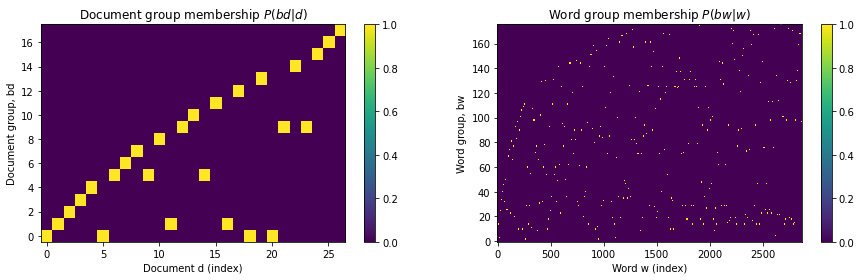

In [157]:
#Plotting thee document group memberships 
p_td_d,p_tw_w = mode2.group_membership()

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.imshow(p_td_d,origin='lower',aspect='auto',interpolation='none')
plt.title(r'Document group membership $P(bd | d)$')
plt.xlabel('Document d (index)')
plt.ylabel('Document group, bd')
plt.colorbar()

plt.subplot(122)
plt.imshow(p_tw_w,origin='lower',aspect='auto',interpolation='none')
plt.title(r'Word group membership $P(bw | w)$')
plt.xlabel('Word w (index)')
plt.ylabel('Word group, bw')
plt.colorbar()

from google.colab import files
plt.savefig("actor_plots2.png")
files.download("actor_plots2.png") 

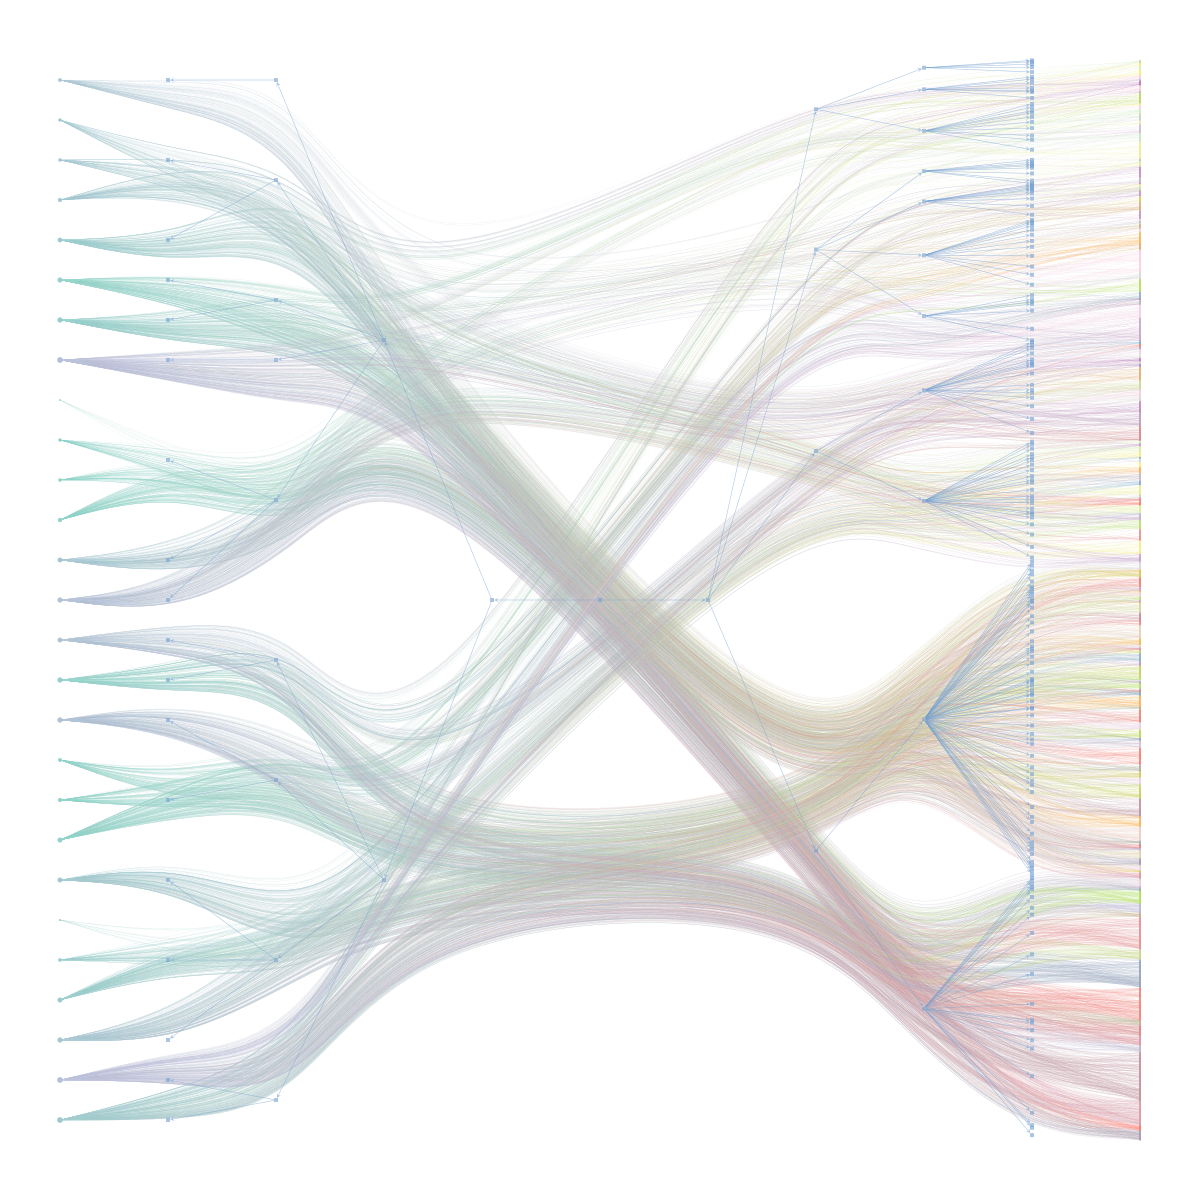

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [165]:
#Plotting the models topic distribution 
mode2.plot(nedges=5000)


## Dictionary

In [28]:
#Import libraries 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import re

In [31]:
#Qualitatively adding names to the top 5 topics for each NGO (only 63 of the topics)
topics_names = {0: "Humanitær krise", 3: "Samarbejde", 4:'Hjælp til udsatte', 6: 'Tak', 7:'DKaid', 8:'DKpol', 10:'Handler stadig',
                12:'Vigtigt', 14:'Områder skal modtage', 15:'Fødevarer sikkerhed', 18:'Opleve nedlukning', 19:'Energi/teknologi',
                20:'Bruge god tid', 25:'Styrke samfundet', 26:'Menneskerettighed', 28:'Udviklingspolitik',
                29:'Positiv', 32:'Stå sammen', 36:'Glad dansker', 40:'Donere til coronavirus', 41:'Barn', 46:'Dansk',
                49:'Lige store', 53:'Forbrydelse', 54:'Demonstration', 60:'Regeringen', 67:'Amnesty - Samtykkelov',
                74:'Asylansøgere og flygtninge', 75:'Danmark', 76:'Tortur', 77:'Risikere', 80:'Flygte', 82:'Lytte',
                83:'Hjem fra Syrien', 94:'Humant lovforslag', 97:'Johanne Schmidt-Nielsen', 98:'Hente børn fra Syrien',
                99:'Danske børn i fangelejrer', 101:'Unge pigers rettigheder', 105:'DKmedier', 110: 'Fyld ord', 113:'Traume',
                116:'Vaccine', 121:'Klima', 123:'Syrisk flygtning', 125:'Udsatte børn og unge', 127:'Indsamling', 130:'Menneskeret',
                131:'Børns rettigheder', 134: 'Hospitals hjælp', 136:'DKsocial', 137:'Kommunal undersøgelse', 145:'Røde Kors',
                148:'Alkohol', 153:'DKgreen', 159:'Humanitær politik', 162:'Fattig', 165:'Klimaforandring', 
                168:'Oxfam Ibis - Skattely', 170:'Hungersnød', 172:'Verdensmålene', 175:'UNICEF-Verdens børn'}

In [32]:
len(topics_names)

62

In [33]:
#Read in and transpose the dataset containing the aggregated topics 
data = pd.read_csv('data_topics.csv', index_col=0)
data = data.transpose()

In [34]:
data.head()

0                            1  \
ADRA_Danmark     (0, 0.04918032786885246)     (6, 0.04918032786885246)   
AVestegnen      (32, 0.04361873990306947)    (54, 0.04254173397953689)   
ActionAidDK     (8, 0.044670717687633435)    (32, 0.04122187551322056)   
BornsVilkar    (125, 0.08345738742091552)    (41, 0.06122069222180871)   
CARE_Danmark  (121, 0.055756324212700055)  (153, 0.044269488900361385)   

                                       2                          3  \
ADRA_Danmark   (20, 0.04918032786885246)   (3, 0.03278688524590164)   
AVestegnen     (67, 0.04092622509423802)  (53, 0.03446418955304254)   
ActionAidDK   (60, 0.030054196091312203)  (82, 0.02874035145344063)   
BornsVilkar   (20, 0.042705619650167476)  (18, 0.03917007815407518)   
CARE_Danmark   (8, 0.035622096024780586)   (7, 0.03265358802271554)   

                                        4  
ADRA_Danmark     (4, 0.03278688524590164)  
AVestegnen     (10, 0.029617662897145933)  
ActionAidDK   (153, 0.028411890293972737)  
BornsVilkar    (131, 0.03275027912169706)  
CARE_Danmark   (165, 0.02968508002065049)

In [20]:
#Function to make string to tuple 
def str_to_tup(str):
  m = re.match(r"\s*\(\s*(\d+)\s*,\s*(0\.\d+)\s*\)\s*", str)
  return (int(m.group(1)), float(m.group(2)))

In [21]:
#Applying function 
data[0] = data[0].apply(str_to_tup)
data[1] = data[1].apply(str_to_tup)
data[2] = data[2].apply(str_to_tup)
data[3] = data[3].apply(str_to_tup)
data[4] = data[4].apply(str_to_tup)

In [22]:
#Adding topic names 
data[0] = data[0].apply(lambda x: (topic_names[x[0]], x[1]))
data[1] = data[1].apply(lambda x: (topic_names[x[0]], x[1]))
data[2] = data[2].apply(lambda x: (topic_names[x[0]], x[1]))
data[3] = data[3].apply(lambda x: (topic_names[x[0]], x[1]))
data[4] = data[4].apply(lambda x: (topic_names[x[0]], x[1]))

In [23]:
#Transpose data again 
data = data.transpose()

#tops = data.to_dict()

In [24]:
#Checking data for one NGO 
data["ADRA_Danmark"]

0      (Humanitær krise, 0.04918032786885246)
1                  (Tak, 0.04918032786885246)
2        (Bruge god tid, 0.04918032786885246)
3           (Samarbejde, 0.03278688524590164)
4    (Hjælp til udsatte, 0.03278688524590164)
Name: ADRA_Danmark, dtype: object

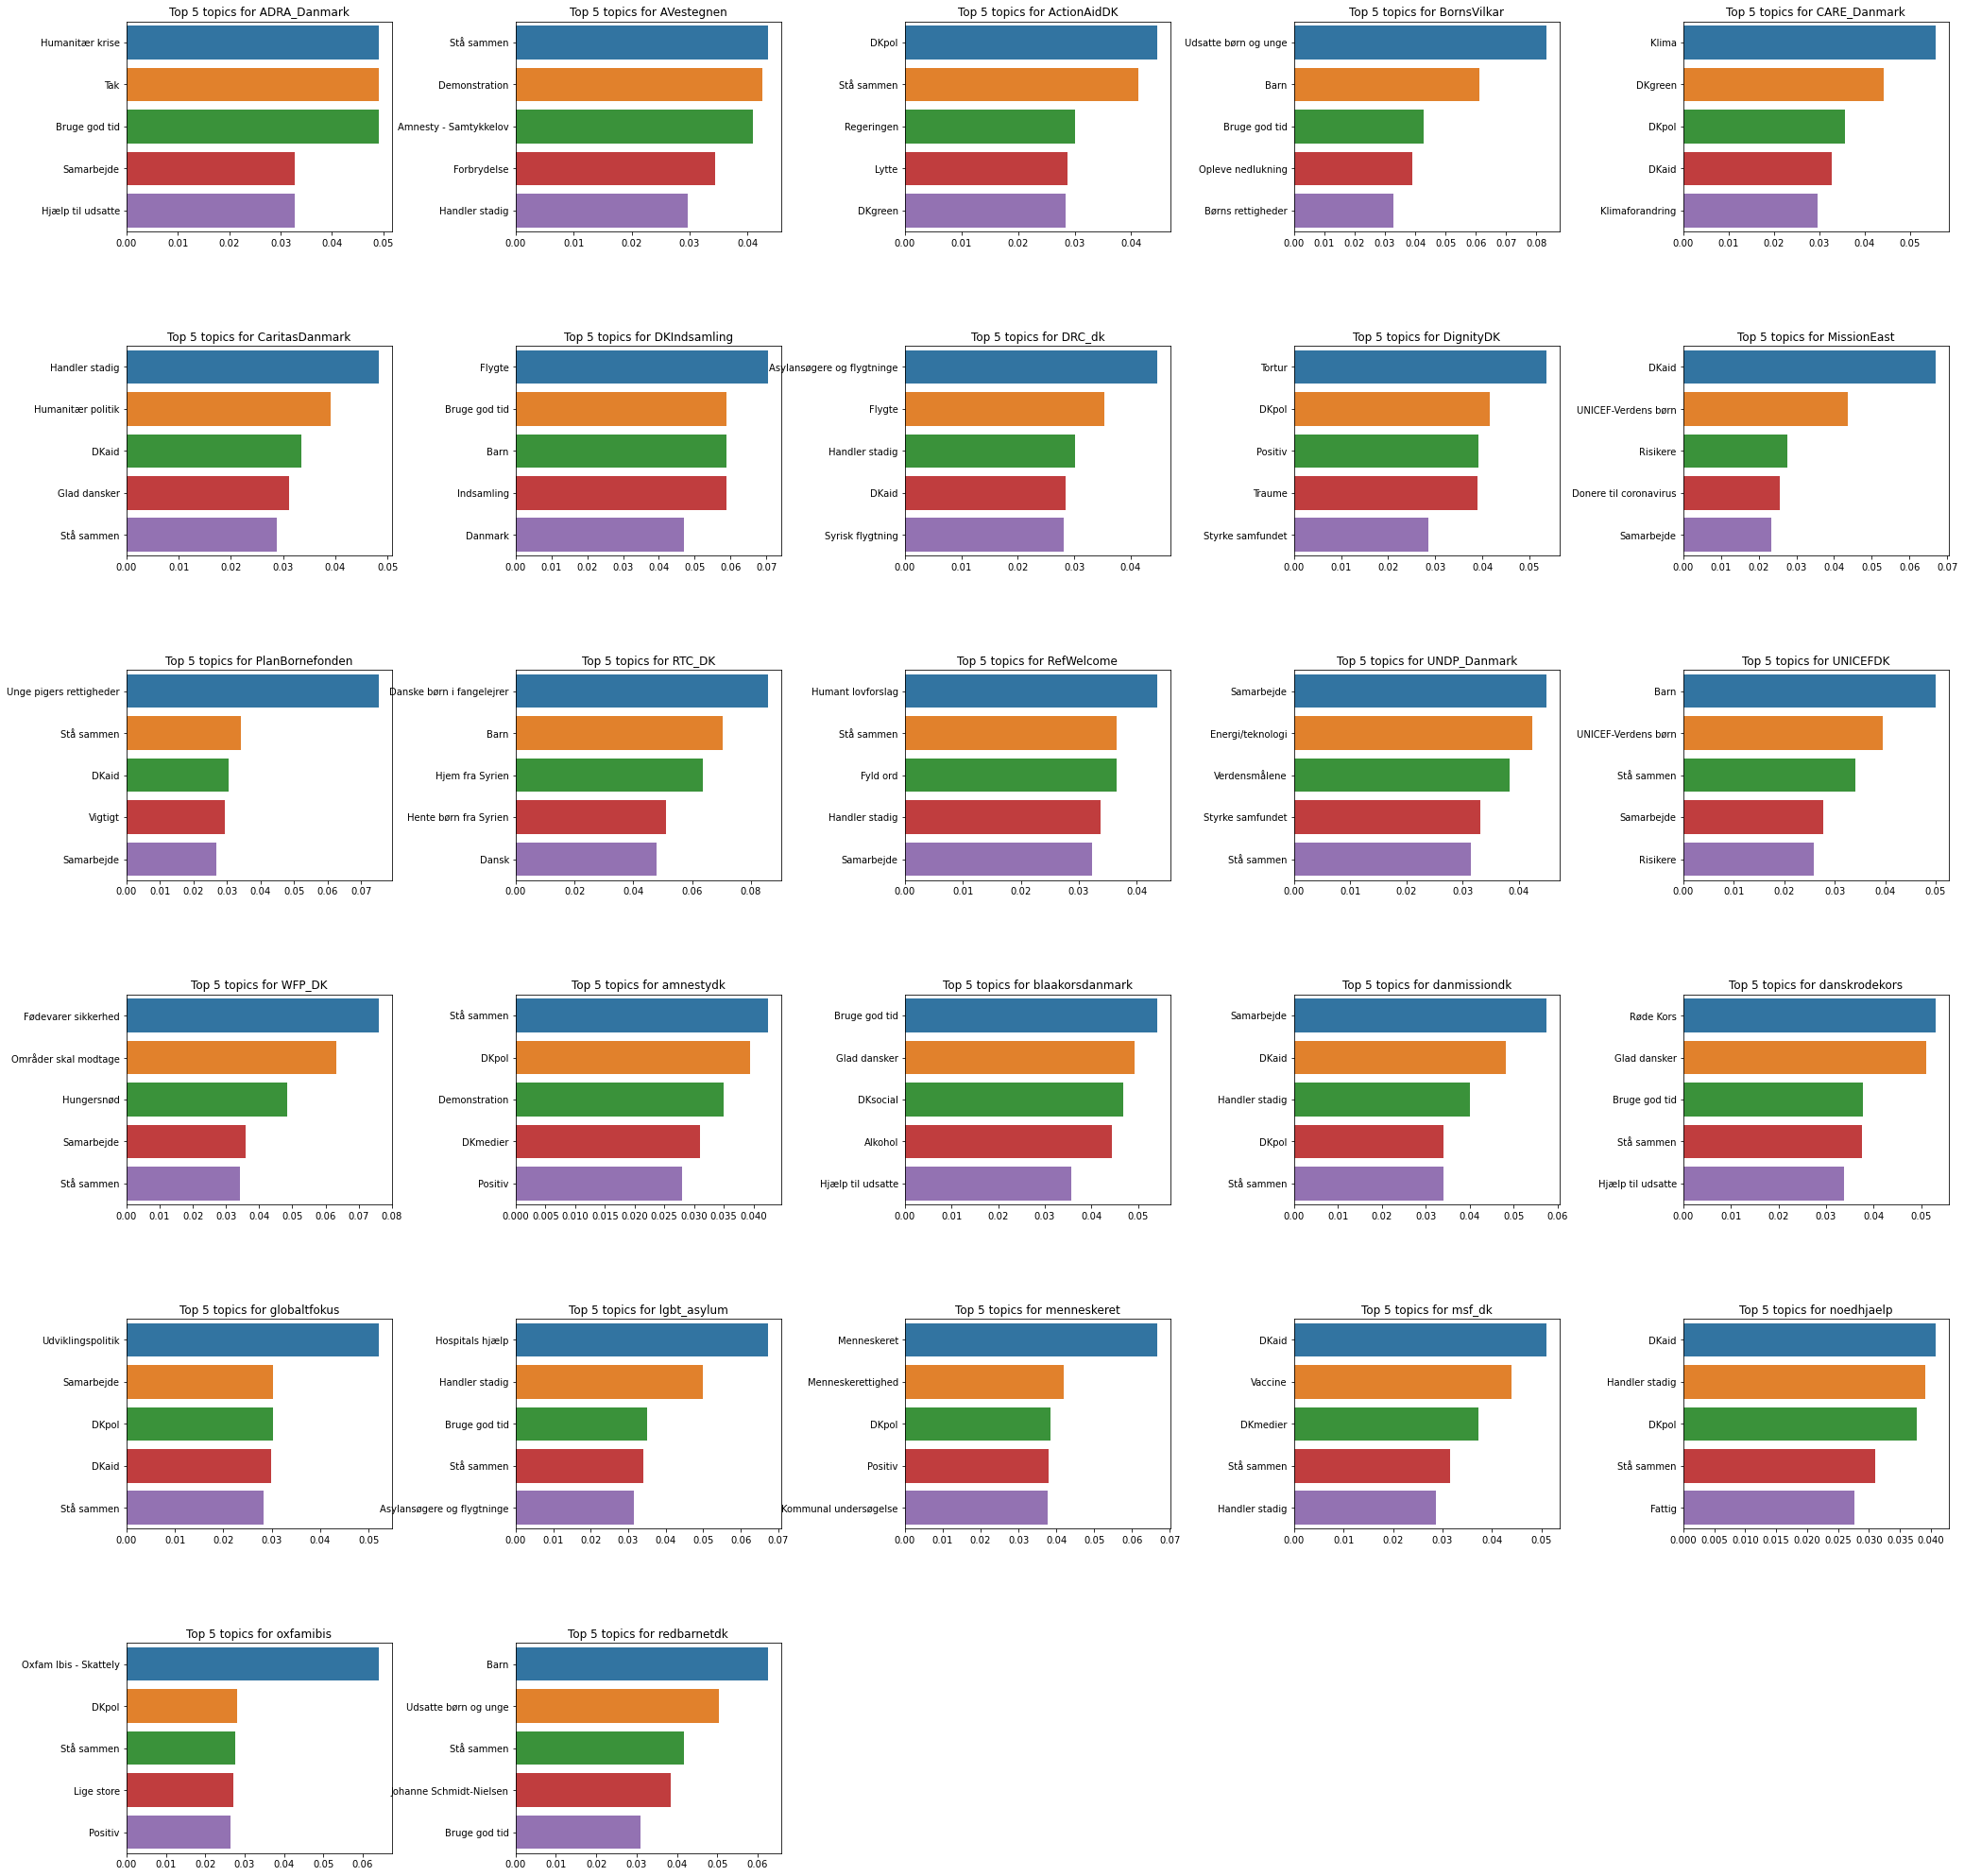

In [25]:
#Plotting top 5 topics for each NGO 
fig, axes = plt.subplots(nrows = 6, ncols = 5, figsize=(30, 30))
fig.tight_layout(pad=10.0)

for ax, actor in zip(axes.flatten(), data):
    
    topics = [t[0] for t in data[actor]]
    scores = [t[1] for t in data[actor]]
    sns.barplot(ax = ax, y = topics, x = scores, orient = "h")
    
    ax.set(title=f'Top 5 topics for {actor}')
    
axes[5][2].set_visible(False)
axes[5][3].set_visible(False)
axes[5][4].set_visible(False)

plt.savefig('hsbm_topics.png', dpi=600)

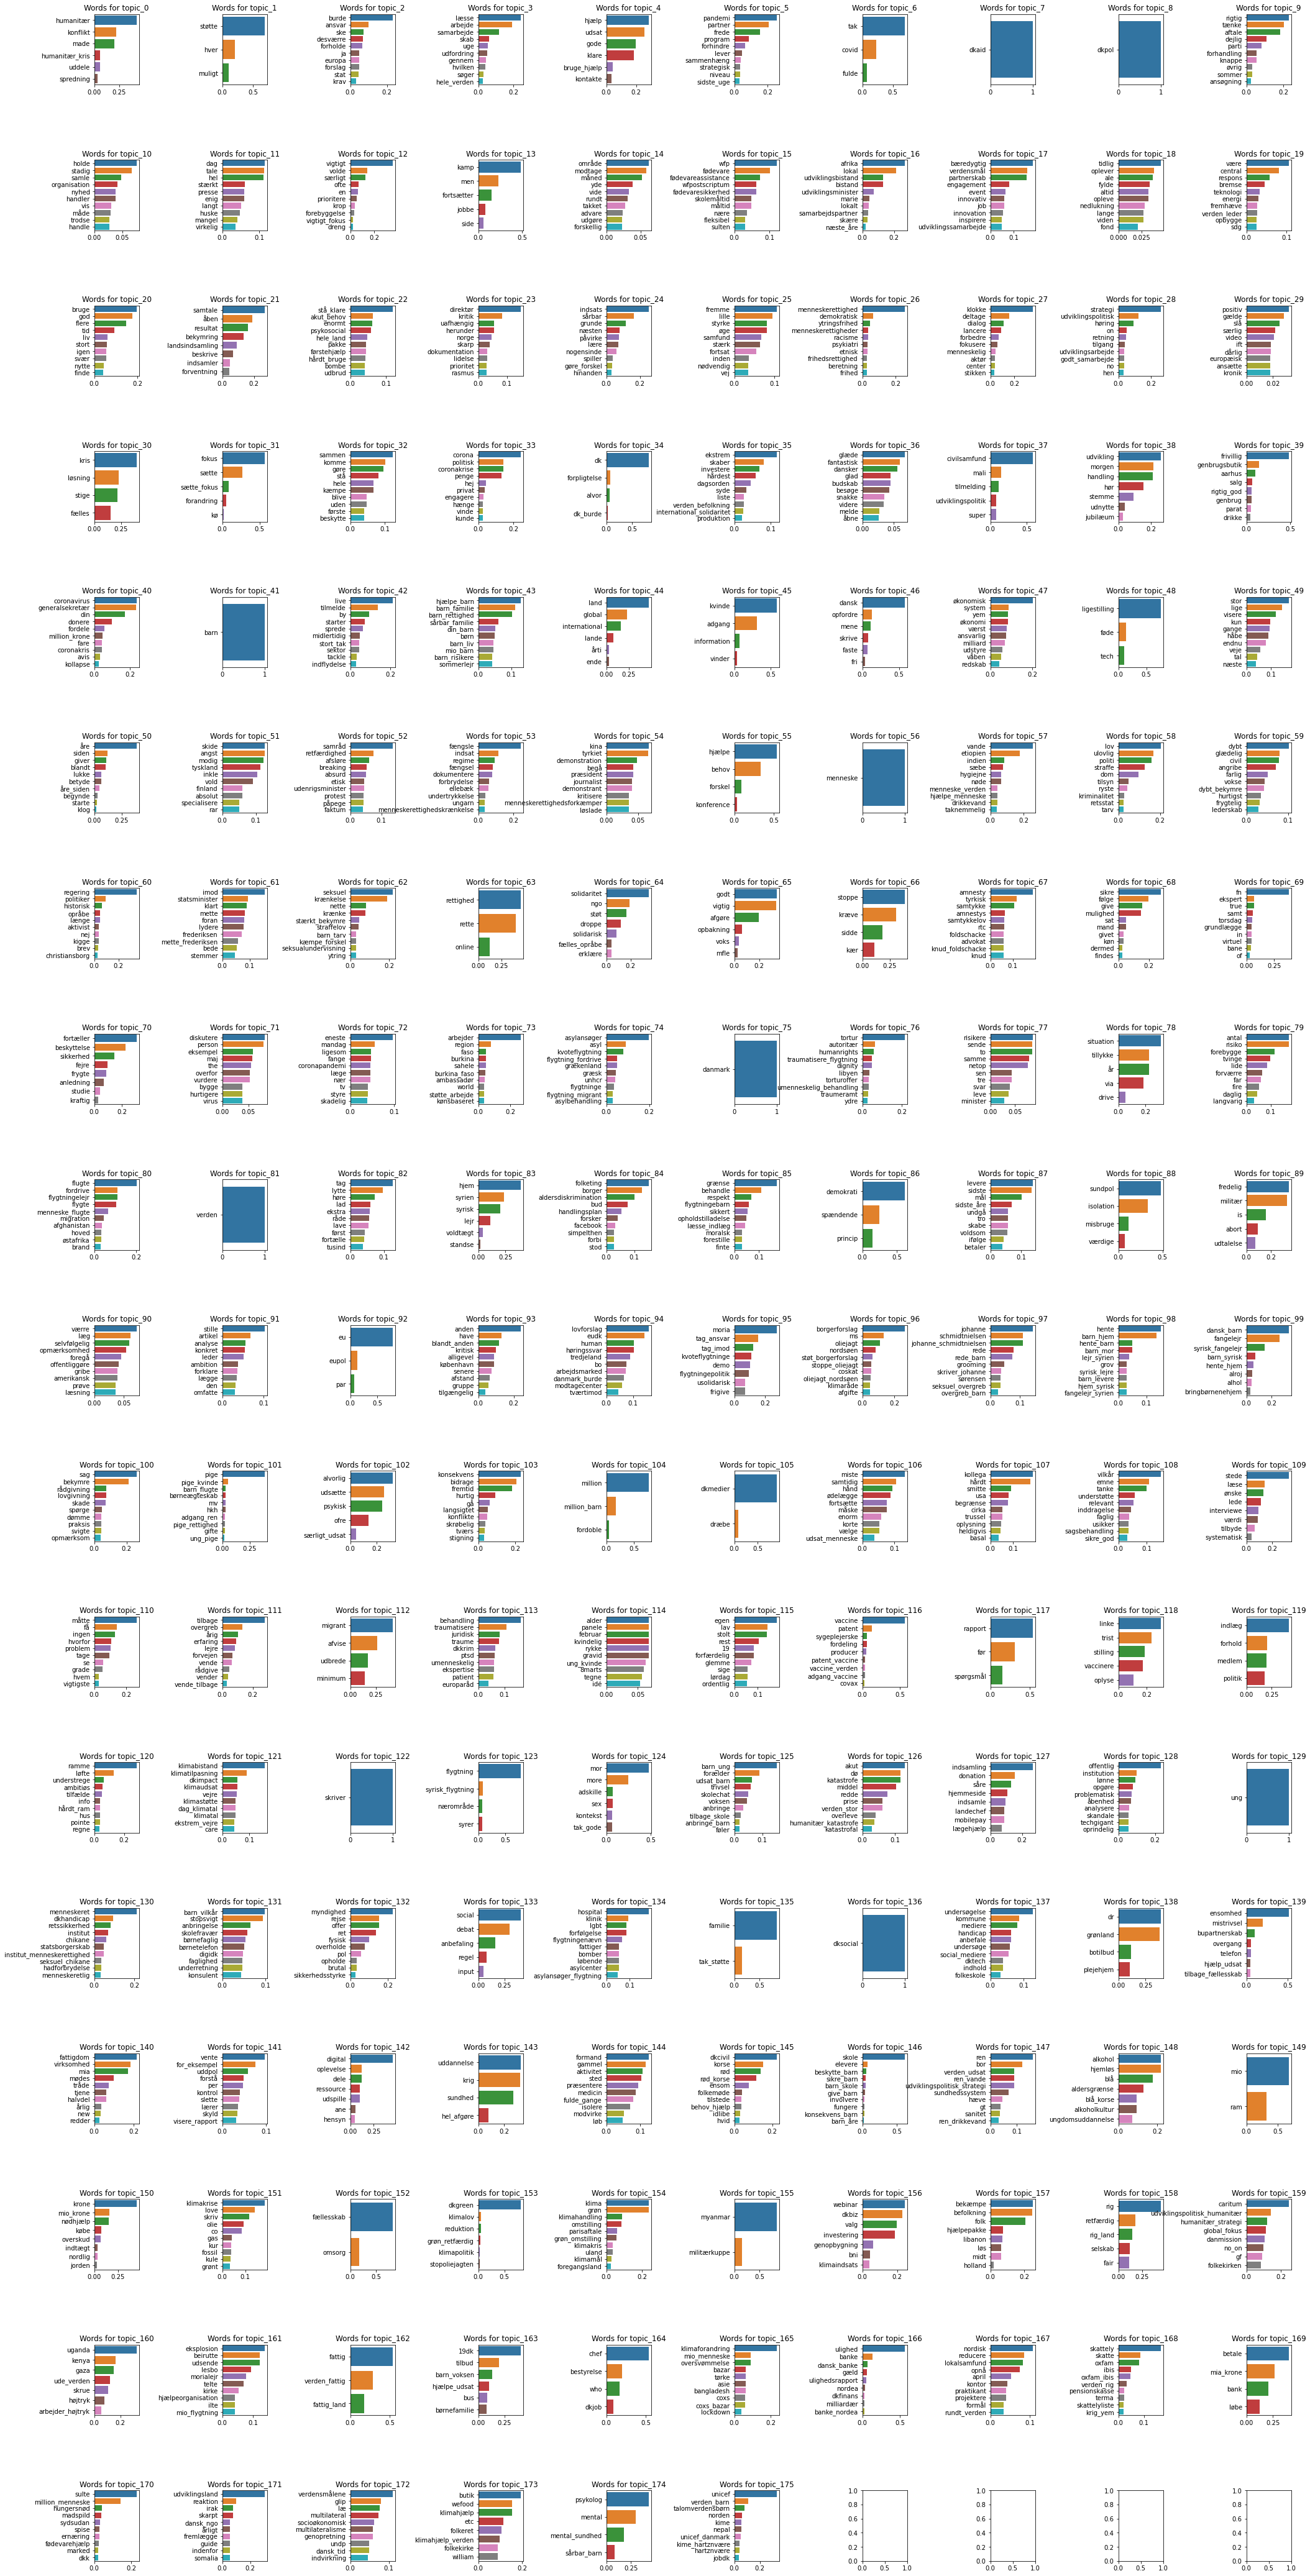

In [27]:
#Plotting words for each topic (and plotting the topics)
fig, axes = plt.subplots(nrows = 18, ncols = 10, figsize=(30, 60),squeeze=False)
fig.tight_layout(pad=10.0)

for ax, (topic, word) in zip(axes.flatten(), dict_topics.items()):
    x = []
    y = []
    for top_num in word:
        y.append(top_num[0])
        x.append(top_num[1])
        #print(top_num[])
    #print(x, y)
    sns.barplot(ax = ax, y = y, x = x, orient='h')
    
    ax.set(title=f'Words for topic_{topic}')
        
plt.savefig('topics_tweets_hsbm.png')        
        
        #sns.barplot(x, y, alpha=0.9,ax = axs[r][c])

# Dict for topics for tweets

In [15]:
#Making dictionary for the 176 topics 
dict_topics = {0: [('humanitær', 0.4289655172413793),
  ('konflikt', 0.22206896551724137),
  ('made', 0.2),
  ('humanitær_kris', 0.057931034482758624),
  ('uddele', 0.057931034482758624),
  ('spredning', 0.03310344827586207)],
 1: [('støtte', 0.6919642857142857),
  ('hver', 0.20625),
  ('muligt', 0.10178571428571428)],
 2: [('burde', 0.23227247347850363),
  ('ansvar', 0.0993858179787828),
  ('ske', 0.07091010608598548),
  ('desværre', 0.06867671691792294),
  ('forholde', 0.06420993858179788),
  ('ja', 0.04913456169737577),
  ('europa', 0.047459519821328865),
  ('forslag', 0.04690117252931323),
  ('stat', 0.044109436069235064),
  ('krav', 0.03238414293690676)],
 3: [('læsse', 0.24259681093394078),
  ('arbejde', 0.190584662110858),
  ('samarbejde', 0.11845102505694761),
  ('skab', 0.06036446469248292),
  ('uge', 0.05239179954441914),
  ('udfordring', 0.050493545937737284),
  ('gennem', 0.04441913439635535),
  ('hvilken', 0.04100227790432802),
  ('søger', 0.030372057706909643),
  ('hele_verden', 0.025436598329536826)],
 4: [('hjælp', 0.2857142857142857),
  ('udsat', 0.25486250838363517),
  ('gode', 0.19584171696847752),
  ('klare', 0.18376928236083165),
  ('bruge_hjælp', 0.043594902749832326),
  ('kontakte', 0.03621730382293763)],
 5: [('pandemi', 0.2560646900269542),
  ('partner', 0.20754716981132076),
  ('frede', 0.15498652291105122),
  ('program', 0.0876010781671159),
  ('forhindre', 0.06334231805929919),
  ('lever', 0.04582210242587601),
  ('sammenhæng', 0.03638814016172507),
  ('strategisk', 0.03369272237196765),
  ('niveau', 0.03369272237196765),
  ('sidste_uge', 0.03099730458221024)],
 6: [('tak', 0.7008695652173913),
  ('covid', 0.2252173913043478),
  ('fulde', 0.07391304347826087)],
 7: [('dkaid', 1.0)],
 8: [('dkpol', 1.0)],
 9: [('rigtig', 0.229957805907173),
  ('tænke', 0.20253164556962025),
  ('aftale', 0.18354430379746836),
  ('dejlig', 0.10759493670886076),
  ('parti', 0.08227848101265822),
  ('forhandling', 0.05485232067510549),
  ('knappe', 0.05485232067510549),
  ('øvrig', 0.03164556962025317),
  ('sommer', 0.029535864978902954),
  ('ansøgning', 0.023206751054852322)],
 10: [('holde', 0.0759493670886076),
  ('stadig', 0.06715893108298171),
  ('samle', 0.048171589310829814),
  ('organisation', 0.04149085794655415),
  ('nyhed', 0.03762306610407876),
  ('handler', 0.03762306610407876),
  ('vis', 0.02988748241912799),
  ('måde', 0.029535864978902954),
  ('trodse', 0.026371308016877638),
  ('handle', 0.026371308016877638)],
 11: [('dag', 0.11550268610897928),
  ('tale', 0.11396776669224866),
  ('hel', 0.11243284727551804),
  ('stærkt', 0.06178050652340752),
  ('presse', 0.0602455871066769),
  ('enig', 0.0602455871066769),
  ('langt', 0.05065234075211052),
  ('huske', 0.047582501918649274),
  ('mangel', 0.04029163468917882),
  ('virkelig', 0.035303146584804296)],
 12: [('vigtigt', 0.35768261964735515),
  ('volde', 0.14021830394626364),
  ('særligt', 0.12510495382031905),
  ('ofte', 0.06717044500419815),
  ('en', 0.0654911838790932),
  ('prioritere', 0.05289672544080604),
  ('krop', 0.038623005877413935),
  ('forebyggelse', 0.031066330814441646),
  ('vigtigt_fokus', 0.02434928631402183),
  ('dreng', 0.022670025188916875)],
 13: [('kamp', 0.48514851485148514),
  ('men', 0.22607260726072606),
  ('fortsætter', 0.1485148514851485),
  ('jobbe', 0.08085808580858085),
  ('side', 0.0594059405940594)],
 14: [('område', 0.0625),
  ('modtage', 0.0586283185840708),
  ('måned', 0.051991150442477874),
  ('yde', 0.03816371681415929),
  ('vide', 0.03263274336283186),
  ('rundt', 0.030973451327433628),
  ('takket', 0.02765486725663717),
  ('advare', 0.024336283185840708),
  ('udgøre', 0.023230088495575223),
  ('forskellig', 0.02267699115044248)],
 15: [('wfp', 0.12176165803108809),
  ('fødevare', 0.10103626943005181),
  ('fødevareassistance', 0.07253886010362694),
  ('wfpostscriptum', 0.06347150259067358),
  ('fødevaresikkerhed', 0.06217616580310881),
  ('skolemåltid', 0.04922279792746114),
  ('måltid', 0.04922279792746114),
  ('nære', 0.03626943005181347),
  ('fleksibel', 0.031088082901554404),
  ('sulten', 0.031088082901554404)],
 16: [('afrika', 0.26800670016750416),
  ('lokal', 0.21273031825795644),
  ('udviklingsbistand', 0.1306532663316583),
  ('bistand', 0.1306532663316583),
  ('udviklingsminister', 0.07035175879396985),
  ('marie', 0.04187604690117253),
  ('lokalt', 0.04020100502512563),
  ('samarbejdspartner', 0.03685092127303183),
  ('skære', 0.03350083752093802),
  ('næste_åre', 0.018425460636515914)],
 17: [('bæredygtig', 0.18315018315018314),
  ('verdensmål', 0.15934065934065933),
  ('partnerskab', 0.15567765567765568),
  ('engagement', 0.08058608058608059),
  ('event', 0.0641025641025641),
  ('innovativ', 0.06043956043956044),
  ('job', 0.06043956043956044),
  ('innovation', 0.05311355311355311),
  ('inspirere', 0.047619047619047616),
  ('udviklingssamarbejde', 0.047619047619047616)],
 18: [('tidlig', 0.046511627906976744),
  ('oplever', 0.03875968992248062),
  ('ale', 0.037306201550387594),
  ('fylde', 0.03391472868217054),
  ('altid', 0.03246124031007752),
  ('opleve', 0.03246124031007752),
  ('nedlukning', 0.028585271317829456),
  ('lange', 0.027616279069767442),
  ('viden', 0.027131782945736434),
  ('fond', 0.02131782945736434)],
 19: [('være', 0.10583941605839416),
  ('central', 0.08150851581508516),
  ('respons', 0.057177615571776155),
  ('bremse', 0.045012165450121655),
  ('teknologi', 0.032846715328467155),
  ('energi', 0.030413625304136254),
  ('fremhæve', 0.0267639902676399),
  ('verden_leder', 0.0267639902676399),
  ('opbygge', 0.025547445255474453),
  ('sdg', 0.025547445255474453)],
 20: [('bruge', 0.19691444600280505),
  ('god', 0.17503506311360448),
  ('flere', 0.14670406732117813),
  ('tid', 0.09200561009817672),
  ('liv', 0.05974754558204769),
  ('stort', 0.057223001402524544),
  ('igen', 0.054137447405329595),
  ('svær', 0.05385694249649369),
  ('nytte', 0.04403927068723703),
  ('finde', 0.04151472650771389)],
 21: [('samtale', 0.2682119205298013),
  ('åben', 0.18874172185430463),
  ('resultat', 0.16225165562913907),
  ('bekymring', 0.13245033112582782),
  ('landsindsamling', 0.09271523178807947),
  ('beskrive', 0.06622516556291391),
  ('indsamler', 0.046357615894039736),
  ('forventning', 0.04304635761589404)],
 22: [('stå_klare', 0.1186046511627907),
  ('akut_behov', 0.06279069767441861),
  ('enormt', 0.06046511627906977),
  ('psykosocial', 0.05813953488372093),
  ('hele_land', 0.046511627906976744),
  ('pakke', 0.044186046511627906),
  ('førstehjælp', 0.044186046511627906),
  ('hårdt_bruge', 0.04186046511627907),
  ('bombe', 0.03953488372093023),
  ('udbrud', 0.03953488372093023)],
 23: [('direktør', 0.14910025706940874),
  ('kritik', 0.08226221079691516),
  ('uafhængig', 0.055269922879177376),
  ('herunder', 0.05398457583547558),
  ('norge', 0.04627249357326478),
  ('skarp', 0.038560411311053984),
  ('dokumentation', 0.030848329048843187),
  ('lidelse', 0.030848329048843187),
  ('prioritet', 0.028277634961439587),
  ('rasmus', 0.028277634961439587)],
 24: [('indsats', 0.25383920505871727),
  ('sårbar', 0.16440831074977416),
  ('grunde', 0.11653116531165311),
  ('næsten', 0.07949412827461608),
  ('påvirke', 0.07588075880758807),
  ('lære', 0.07226738934056007),
  ('nogensinde', 0.05871725383920506),
  ('spiller', 0.03884372177055104),
  ('gøre_forskel', 0.03523035230352303),
  ('hinanden', 0.031616982836495035)],
 25: [('fremme', 0.10613397901533494),
  ('lille', 0.09483454398708636),
  ('styrke', 0.08151735270379339),
  ('øge', 0.0811138014527845),
  ('samfund', 0.06658595641646489),
  ('stærk', 0.06335754640839386),
  ('fortsat', 0.05488297013720742),
  ('inden', 0.03631961259079903),
  ('nødvendig', 0.03430185633575464),
  ('vej', 0.03389830508474576)],
 26: [('menneskerettighed', 0.2563600782778865),
  ('demokratisk', 0.06555772994129158),
  ('ytringsfrihed', 0.04598825831702544),
  ('menneskerettigheder', 0.03522504892367906),
  ('racisme', 0.03522504892367906),
  ('psykiatri', 0.03131115459882583),
  ('etnisk', 0.03131115459882583),
  ('frihedsrettighed', 0.02837573385518591),
  ('beretning', 0.026418786692759294),
  ('frihed', 0.025440313111545987)],
 27: [('klokke', 0.35526315789473684),
  ('deltage', 0.1564327485380117),
  ('dialog', 0.10818713450292397),
  ('lancere', 0.08771929824561403),
  ('forbedre', 0.06871345029239766),
  ('fokusere', 0.05847953216374269),
  ('menneskelig', 0.043859649122807015),
  ('aktør', 0.038011695906432746),
  ('center', 0.03654970760233918),
  ('stikken', 0.03070175438596491)],
 28: [('strategi', 0.26055045871559634),
  ('udviklingspolitisk', 0.12293577981651377),
  ('høring', 0.09174311926605505),
  ('on', 0.04954128440366973),
  ('retning', 0.045871559633027525),
  ('tilgang', 0.03853211009174312),
  ('udviklingsarbejde', 0.03669724770642202),
  ('godt_samarbejde', 0.03486238532110092),
  ('no', 0.03486238532110092),
  ('hen', 0.03302752293577982)],
 29: [('positiv', 0.03218727139722019),
  ('gælde', 0.02852962692026335),
  ('slå', 0.02487198244330651),
  ('særlig', 0.021580102414045354),
  ('video', 0.020848573518653987),
  ('ift', 0.018653986832479885),
  ('dårlig', 0.018288222384784197),
  ('europæisk', 0.017922457937088514),
  ('ansætte', 0.017922457937088514),
  ('kronik', 0.017922457937088514)],
 30: [('kris', 0.3992443324937028),
  ('løsning', 0.22921914357682618),
  ('stige', 0.21914357682619648),
  ('fælles', 0.15239294710327456)],
 31: [('fokus', 0.5709923664122137),
  ('sætte', 0.2687022900763359),
  ('sætte_fokus', 0.08702290076335878),
  ('forandring', 0.0549618320610687),
  ('kø', 0.0183206106870229)],
 32: [('sammen', 0.12298387096774194),
  ('komme', 0.10170250896057348),
  ('gøre', 0.09565412186379928),
  ('stå', 0.08086917562724015),
  ('hele', 0.06653225806451613),
  ('kæmpe', 0.06608422939068101),
  ('blive', 0.04704301075268817),
  ('uden', 0.04704301075268817),
  ('første', 0.039874551971326166),
  ('beskytte', 0.03920250896057348)],
 33: [('corona', 0.24326672458731538),
  ('politisk', 0.1424847958297133),
  ('coronakrise', 0.1416159860990443),
  ('penge', 0.13292788879235448),
  ('hej', 0.043440486533449174),
  ('privat', 0.035621198957428324),
  ('engagere', 0.030408340573414423),
  ('hænge', 0.02693310165073849),
  ('vinde', 0.026064291920069503),
  ('kunde', 0.026064291920069503)],
 34: [('dk', 0.8279158699808795),
  ('forpligtelse', 0.08030592734225621),
  ('alvor', 0.06118546845124283),
  ('dk_burde', 0.030592734225621414)],
 35: [('ekstrem', 0.11708860759493671),
  ('skaber', 0.08016877637130802),
  ('investere', 0.06962025316455696),
  ('hårdest', 0.0580168776371308),
  ('dagsorden', 0.04430379746835443),
  ('syde', 0.03270042194092827),
  ('liste', 0.026371308016877638),
  ('verden_befolkning', 0.02531645569620253),
  ('international_solidaritet', 0.024261603375527425),
  ('produktion', 0.020042194092827006)],
 36: [('glæde', 0.06801379990142928),
  ('fantastisk', 0.05963528831936915),
  ('dansker', 0.056185312962050274),
  ('glad', 0.045342533267619514),
  ('budskab', 0.04484967964514539),
  ('besøge', 0.04337111877772302),
  ('snakke', 0.03449975357318876),
  ('videre', 0.03351404632824051),
  ('melde', 0.02661409561360276),
  ('åbne', 0.025628388368654508)],
 37: [('civilsamfund', 0.5851063829787234),
  ('mali', 0.14893617021276595),
  ('tilmelding', 0.11347517730496454),
  ('udviklingspolitik', 0.07801418439716312),
  ('super', 0.07446808510638298)],
 38: [('udvikling', 0.2612359550561798),
  ('morgen', 0.2148876404494382),
  ('handling', 0.21067415730337077),
  ('hør', 0.1544943820224719),
  ('stemme', 0.09129213483146068),
  ('udnytte', 0.03932584269662921),
  ('jubilæum', 0.028089887640449437)],
 39: [('frivillig', 0.4844290657439446),
  ('genbrugsbutik', 0.14186851211072665),
  ('aarhus', 0.10034602076124567),
  ('salg', 0.0657439446366782),
  ('rigtig_god', 0.05536332179930796),
  ('genbrug', 0.05536332179930796),
  ('parat', 0.05190311418685121),
  ('drikke', 0.04498269896193772)],
 40: [('coronavirus', 0.23719165085388993),
  ('generalsekretær', 0.2333965844402277),
  ('din', 0.17077798861480076),
  ('donere', 0.0967741935483871),
  ('fordele', 0.056925996204933584),
  ('million_krone', 0.04554079696394687),
  ('fare', 0.04364326375711575),
  ('coronakris', 0.04174573055028463),
  ('avis', 0.030360531309297913),
  ('kollapse', 0.024667931688804556)],
 41: [('barn', 1.0)],
 42: [('live', 0.21231766612641814),
  ('tilmelde', 0.13776337115072934),
  ('by', 0.09238249594813615),
  ('starter', 0.07293354943273905),
  ('sprede', 0.06320907617504051),
  ('midlertidig', 0.04862236628849271),
  ('stort_tak', 0.04376012965964344),
  ('sektor', 0.04376012965964344),
  ('tackle', 0.03079416531604538),
  ('indflydelse', 0.027552674230145867)],
 43: [('hjælpe_barn', 0.12926829268292683),
  ('barn_familie', 0.11219512195121951),
  ('barn_rettighed', 0.1024390243902439),
  ('sårbar_familie', 0.06097560975609756),
  ('din_barn', 0.05121951219512195),
  ('børn', 0.04878048780487805),
  ('barn_liv', 0.046341463414634146),
  ('mio_barn', 0.046341463414634146),
  ('barn_risikere', 0.041463414634146344),
  ('sommerlejr', 0.041463414634146344)],
 44: [('land', 0.4731766124171187),
  ('global', 0.22664255575647982),
  ('international', 0.16335141651597349),
  ('lande', 0.07836045810729356),
  ('årti', 0.03134418324291742),
  ('ende', 0.027124773960216998)],
 45: [('kvinde', 0.5864759427828349),
  ('adgang', 0.3094928478543563),
  ('information', 0.07152145643693109),
  ('vinder', 0.032509752925877766)],
 46: [('dansk', 0.5822550831792976),
  ('opfordre', 0.1266173752310536),
  ('mene', 0.11182994454713494),
  ('skrive', 0.07578558225508318),
  ('faste', 0.06746765249537892),
  ('fri', 0.036044362292051754)],
 47: [('økonomisk', 0.20314389359129384),
  ('system', 0.08585247883917775),
  ('yem', 0.08464328899637243),
  ('økonomi', 0.08222490931076179),
  ('værst', 0.0773881499395405),
  ('ansvarlig', 0.0761789600967352),
  ('milliard', 0.07013301088270858),
  ('udstyre', 0.05562273276904474),
  ('våben', 0.049576783555018135),
  ('redskab', 0.041112454655380895)],
 48: [('ligestilling', 0.7591836734693878),
  ('føde', 0.1346938775510204),
  ('tech', 0.10612244897959183)],
 49: [('stor', 0.17239983812221774),
  ('lige', 0.14447592067988668),
  ('visere', 0.11938486442735735),
  ('kun', 0.09510319708619992),
  ('gange', 0.09307972480777013),
  ('håbe', 0.08781869688385269),
  ('endnu', 0.07891541885876163),
  ('veje', 0.05584783488466208),
  ('tal', 0.043707001214083364),
  ('næste', 0.03885066774585188)],
 50: [('åre', 0.38879645036051025),
  ('siden', 0.11758180809761509),
  ('giver', 0.10815307820299501),
  ('blandt', 0.10537992235163617),
  ('lukke', 0.06544647809206877),
  ('betyde', 0.06211869107043816),
  ('åre_siden', 0.04547975596228508),
  ('begynde', 0.03050471436494731),
  ('starte', 0.021630615640599003),
  ('klog', 0.020521353300055462)],
 51: [('skide', 0.12669683257918551),
  ('angst', 0.12669683257918551),
  ('modig', 0.12217194570135746),
  ('tyskland', 0.11312217194570136),
  ('inkle', 0.10407239819004525),
  ('vold', 0.09049773755656108),
  ('finland', 0.058823529411764705),
  ('absolut', 0.058823529411764705),
  ('specialisere', 0.049773755656108594),
  ('rar', 0.049773755656108594)],
 52: [('samråd', 0.13681592039800994),
  ('retfærdighed', 0.07462686567164178),
  ('afsløre', 0.05970149253731343),
  ('breaking', 0.05223880597014925),
  ('absurd', 0.04975124378109453),
  ('etisk', 0.04477611940298507),
  ('udenrigsminister', 0.04477611940298507),
  ('protest', 0.04228855721393035),
  ('påpege', 0.04228855721393035),
  ('faktum', 0.03980099502487562)],
 53: [('fængsle', 0.24299065420560748),
  ('indsat', 0.11588785046728972),
  ('regime', 0.09158878504672897),
  ('fængsel', 0.08411214953271028),
  ('dokumentere', 0.08037383177570094),
  ('forbrydelse', 0.0616822429906542),
  ('ellebæk', 0.056074766355140186),
  ('undertrykkelse', 0.041121495327102804),
  ('ungarn', 0.037383177570093455),
  ('menneskerettighedskrænkelse', 0.037383177570093455)],
 54: [('kina', 0.06745362563237774),
  ('tyrkiet', 0.0657672849915683),
  ('demonstration', 0.048903878583473864),
  ('begå', 0.04215851602023609),
  ('præsident', 0.04215851602023609),
  ('journalist', 0.04047217537942664),
  ('demonstrant', 0.04047217537942664),
  ('kritisere', 0.03541315345699832),
  ('menneskerettighedsforkæmper', 0.03541315345699832),
  ('løslade', 0.03541315345699832)],
 55: [('hjælpe', 0.5413461538461538),
  ('behov', 0.3326923076923077),
  ('forskel', 0.09134615384615384),
  ('konference', 0.03461538461538462)],
 56: [('menneske', 1.0)],
 57: [('vande', 0.25692695214105793),
  ('etiopien', 0.17884130982367757),
  ('indien', 0.08312342569269521),
  ('sæbe', 0.07556675062972293),
  ('hygiejne', 0.0654911838790932),
  ('nøde', 0.06297229219143577),
  ('menneske_verden', 0.04030226700251889),
  ('hjælpe_menneske', 0.04030226700251889),
  ('drikkevand', 0.04030226700251889),
  ('taknemmelig', 0.037783375314861464)],
 58: [('lov', 0.2049335863377609),
  ('ulovlig', 0.16698292220113853),
  ('politi', 0.15939278937381404),
  ('straffe', 0.1252371916508539),
  ('dom', 0.0967741935483871),
  ('tilsyn', 0.04933586337760911),
  ('ryste', 0.04174573055028463),
  ('kriminalitet', 0.028462998102466792),
  ('retsstat', 0.024667931688804556),
  ('tarv', 0.024667931688804556)],
 59: [('dybt', 0.10235131396957123),
  ('glædelig', 0.07883817427385892),
  ('civil', 0.07745504840940526),
  ('angribe', 0.07053941908713693),
  ('farlig', 0.051175656984785614),
  ('vokse', 0.04426002766251729),
  ('dybt_bekymre', 0.04149377593360996),
  ('hurtigst', 0.034578146611341634),
  ('frygtelig', 0.0318118948824343),
  ('lederskab', 0.029045643153526972)],
 60: [('regering', 0.352112676056338),
  ('politiker', 0.09483568075117371),
  ('historisk', 0.061971830985915494),
  ('opråbe', 0.046948356807511735),
  ('længe', 0.046009389671361506),
  ('aktivist', 0.03943661971830986),
  ('nej', 0.03755868544600939),
  ('kigge', 0.03568075117370892),
  ('brev', 0.03380281690140845),
  ('christiansborg', 0.028169014084507043)],
 61: [('imod', 0.15602836879432624),
  ('statsminister', 0.09397163120567376),
  ('klart', 0.08865248226950355),
  ('mette', 0.08156028368794327),
  ('foran', 0.0797872340425532),
  ('lydere', 0.07801418439716312),
  ('frederiksen', 0.07092198581560284),
  ('mette_frederiksen', 0.05851063829787234),
  ('bede', 0.05319148936170213),
  ('stemmer', 0.04609929078014184)],
 62: [('seksuel', 0.22014051522248243),
  ('krænkelse', 0.1920374707259953),
  ('nette', 0.08196721311475409),
  ('krænke', 0.07728337236533958),
  ('stærkt_bekymre', 0.04449648711943794),
  ('straffelov', 0.04215456674473068),
  ('barn_tarv', 0.02810304449648712),
  ('kæmpe_forskel', 0.02810304449648712),
  ('seksualundervisning', 0.02810304449648712),
  ('ytring', 0.02810304449648712)],
 63: [('rettighed', 0.4655493482309125),
  ('rette', 0.41154562383612664),
  ('online', 0.12290502793296089)],
 64: [('solidaritet', 0.3516483516483517),
  ('ngo', 0.19230769230769232),
  ('støt', 0.16758241758241757),
  ('droppe', 0.12087912087912088),
  ('solidarisk', 0.08241758241758242),
  ('fælles_opråbe', 0.04395604395604396),
  ('erklære', 0.04120879120879121)],
 65: [('godt', 0.34459459459459457),
  ('vigtig', 0.33614864864864863),
  ('afgøre', 0.19932432432432431),
  ('opbakning', 0.060810810810810814),
  ('voks', 0.03462837837837838),
  ('mfle', 0.024493243243243243)],
 66: [('stoppe', 0.39148073022312374),
  ('kræve', 0.31237322515212984),
  ('sidde', 0.1845841784989858),
  ('kær', 0.11156186612576065)],
 67: [('amnesty', 0.1903114186851211),
  ('tyrkisk', 0.11764705882352941),
  ('samtykke', 0.10726643598615918),
  ('amnestys', 0.0657439446366782),
  ('samtykkelov', 0.06228373702422145),
  ('rtc', 0.06228373702422145),
  ('foldschacke', 0.058823529411764705),
  ('advokat', 0.058823529411764705),
  ('knud_foldschacke', 0.058823529411764705),
  ('knud', 0.058823529411764705)],
 68: [('sikre', 0.27994011976047906),
  ('følge', 0.19760479041916168),
  ('give', 0.15494011976047903),
  ('mulighed', 0.1474550898203593),
  ('sat', 0.04940119760479042),
  ('mand', 0.04790419161676647),
  ('givet', 0.035179640718562874),
  ('køn', 0.035179640718562874),
  ('dermed', 0.02619760479041916),
  ('findes', 0.02619760479041916)],
 69: [('fn', 0.3850782190132371),
  ('ekspert', 0.06859205776173286),
  ('true', 0.06738868832731648),
  ('samt', 0.056558363417569195),
  ('torsdag', 0.052948255114320095),
  ('grundlægge', 0.048134777376654635),
  ('in', 0.04693140794223827),
  ('virtuel', 0.04693140794223827),
  ('bane', 0.03850782190132371),
  ('of', 0.030084235860409144)],
 70: [('fortæller', 0.30718954248366015),
  ('beskyttelse', 0.22712418300653595),
  ('sikkerhed', 0.1437908496732026),
  ('fejre', 0.09640522875816994),
  ('frygte', 0.08660130718954248),
  ('anledning', 0.07026143790849673),
  ('studie', 0.042483660130718956),
  ('kraftig', 0.026143790849673203)],
 71: [('diskutere', 0.08161044613710555),
  ('person', 0.0794341675734494),
  ('eksempel', 0.058759521218716),
  ('maj', 0.05767138193688792),
  ('the', 0.055495103373231776),
  ('overfor', 0.05223068552774755),
  ('vurdere', 0.05223068552774755),
  ('bygge', 0.03808487486398259),
  ('hurtigere', 0.03808487486398259),
  ('virus', 0.03808487486398259)],
 72: [('eneste', 0.0976),
  ('mandag', 0.056),
  ('ligesom', 0.048),
  ('fange', 0.048),
  ('coronapandemi', 0.0464),
  ('læge', 0.0464),
  ('nær', 0.0464),
  ('tv', 0.04),
  ('styre', 0.04),
  ('skadelig', 0.0384)],
 73: [('arbejder', 0.2668360864040661),
  ('region', 0.07750952986022872),
  ('faso', 0.045743329097839895),
  ('burkina', 0.045743329097839895),
  ('sahele', 0.045743329097839895),
  ('burkina_faso', 0.044472681067344345),
  ('ambassadør', 0.03811944091486658),
  ('world', 0.036848792884371026),
  ('støtte_arbejde', 0.03430749682337993),
  ('kønsbaseret', 0.03430749682337993)],
 74: [('asylansøger', 0.198943661971831),
  ('asyl', 0.09154929577464789),
  ('kvoteflygtning', 0.07922535211267606),
  ('flygtning_fordrive', 0.04929577464788732),
  ('grækenland', 0.04929577464788732),
  ('græsk', 0.04401408450704225),
  ('unhcr', 0.04225352112676056),
  ('flygtninge', 0.035211267605633804),
  ('flygtning_migrant', 0.02992957746478873),
  ('asylbehandling', 0.028169014084507043)],
 75: [('danmark', 1.0)],
 76: [('tortur', 0.21671018276762402),
  ('autoritær', 0.06527415143603134),
  ('humanrights', 0.05613577023498695),
  ('traumatisere_flygtning', 0.048302872062663184),
  ('dignity', 0.04699738903394256),
  ('libyen', 0.03524804177545692),
  ('torturoffer', 0.03263707571801567),
  ('umenneskelig_behandling', 0.031331592689295036),
  ('traumeramt', 0.028720626631853787),
  ('ydre', 0.024804177545691905)],
 77: [('risikere', 0.08670181605155243),
  ('sende', 0.0849443468072642),
  ('to', 0.0849443468072642),
  ('samme', 0.07850029291154072),
  ('netop', 0.07615700058582309),
  ('sen', 0.043936731107205626),
  ('tre', 0.043350908025776215),
  ('svar', 0.03983596953719976),
  ('leve', 0.03690685413005272),
  ('minister', 0.02870533099004101)],
 78: [('situation', 0.314785373608903),
  ('tillykke', 0.2273449920508744),
  ('år', 0.22575516693163752),
  ('via', 0.18282988871224165),
  ('drive', 0.0492845786963434)],
 79: [('antal', 0.1760355029585799),
  ('risiko', 0.17455621301775148),
  ('forebygge', 0.11686390532544379),
  ('tvinge', 0.09911242603550297),
  ('lide', 0.08579881656804733),
  ('forværre', 0.0650887573964497),
  ('far', 0.05917159763313609),
  ('fire', 0.051775147928994084),
  ('daglig', 0.04437869822485207),
  ('langvarig', 0.03254437869822485)],
 80: [('flugte', 0.20365535248041775),
  ('fordrive', 0.10966057441253264),
  ('flygtningelejr', 0.10966057441253264),
  ('flygte', 0.10574412532637076),
  ('menneske_flugte', 0.06657963446475196),
  ('migration', 0.044386422976501305),
  ('afghanistan', 0.03655352480417755),
  ('hoved', 0.033942558746736295),
  ('østafrika', 0.033942558746736295),
  ('brand', 0.030026109660574413)],
 81: [('verden', 1.0)],
 82: [('tag', 0.1266944734098019),
  ('lytte', 0.09697601668404589),
  ('høre', 0.07247132429614181),
  ('lad', 0.06047966631908238),
  ('ekstra', 0.05735140771637122),
  ('råde', 0.056308654848800835),
  ('lave', 0.053180396246089674),
  ('først', 0.043274244004171014),
  ('fortælle', 0.04171011470281543),
  ('tusind', 0.038060479666319084)],
 83: [('hjem', 0.3918757467144564),
  ('syrien', 0.23416965352449223),
  ('syrisk', 0.2031063321385902),
  ('lejr', 0.11230585424133811),
  ('voldtægt', 0.03942652329749104),
  ('standse', 0.019115890083632018)],
 84: [('folketing', 0.15281899109792285),
  ('borger', 0.12759643916913946),
  ('aldersdiskrimination', 0.10089020771513353),
  ('bud', 0.07566765578635015),
  ('handlingsplan', 0.05341246290801187),
  ('forsker', 0.040059347181008904),
  ('facebook', 0.032640949554896145),
  ('simpelthen', 0.028189910979228485),
  ('forbi', 0.028189910979228485),
  ('stod', 0.028189910979228485)],
 85: [('grænse', 0.17407407407407408),
  ('behandle', 0.10925925925925926),
  ('respekt', 0.07037037037037037),
  ('flygtningebarn', 0.05925925925925926),
  ('sikkert', 0.053703703703703705),
  ('opholdstilladelse', 0.05),
  ('læsse_indlæg', 0.044444444444444446),
  ('moralsk', 0.03148148148148148),
  ('forestille', 0.03148148148148148),
  ('finte', 0.03148148148148148)],
 86: [('demokrati', 0.6157205240174672),
  ('spændende', 0.24017467248908297),
  ('princip', 0.14410480349344978)],
 87: [('levere', 0.1391614629794826),
  ('sidste', 0.13380909901873328),
  ('mål', 0.10258697591436218),
  ('sidste_åre', 0.06868867082961641),
  ('undgå', 0.057091882247992866),
  ('tro', 0.057091882247992866),
  ('skabe', 0.057091882247992866),
  ('voldsom', 0.05530776092774309),
  ('ifølge', 0.043710972346119537),
  ('betaler', 0.039250669045495096)],
 88: [('sundpol', 0.48292682926829267),
  ('isolation', 0.33170731707317075),
  ('misbruge', 0.11219512195121951),
  ('værdige', 0.07317073170731707)],
 89: [('fredelig', 0.34710743801652894),
  ('militær', 0.3305785123966942),
  ('is', 0.15702479338842976),
  ('abort', 0.09090909090909091),
  ('udtalelse', 0.0743801652892562)],
 90: [('værre', 0.07207207207207207),
  ('læg', 0.06126126126126126),
  ('selvfølgelig', 0.05945945945945946),
  ('opmærksomhed', 0.05405405405405406),
  ('foregå', 0.04504504504504504),
  ('offentliggøre', 0.04144144144144144),
  ('gribe', 0.03963963963963964),
  ('amerikansk', 0.03963963963963964),
  ('prøve', 0.036036036036036036),
  ('læsning', 0.036036036036036036)],
 91: [('stille', 0.10315985130111524),
  ('artikel', 0.06784386617100371),
  ('analyse', 0.055762081784386616),
  ('konkret', 0.05483271375464684),
  ('leder', 0.05111524163568773),
  ('ambition', 0.03810408921933085),
  ('forklare', 0.0362453531598513),
  ('lægge', 0.03531598513011153),
  ('den', 0.031598513011152414),
  ('omfatte', 0.03066914498141264)],
 92: [('eu', 0.7905604719764012),
  ('eupol', 0.13274336283185842),
  ('par', 0.07669616519174041)],
 93: [('anden', 0.2408906882591093),
  ('have', 0.13157894736842105),
  ('blandt_anden', 0.11538461538461539),
  ('kritisk', 0.09919028340080972),
  ('alligevel', 0.08704453441295547),
  ('københavn', 0.08704453441295547),
  ('senere', 0.07489878542510121),
  ('afstand', 0.06477732793522267),
  ('gruppe', 0.058704453441295545),
  ('tilgængelig', 0.04048582995951417)],
 94: [('lovforslag', 0.16013071895424835),
  ('eudk', 0.1437908496732026),
  ('human', 0.10457516339869281),
  ('høringssvar', 0.10457516339869281),
  ('tredjeland', 0.08823529411764706),
  ('bo', 0.07516339869281045),
  ('arbejdsmarked', 0.0718954248366013),
  ('danmark_burde', 0.06535947712418301),
  ('modtagecenter', 0.058823529411764705),
  ('tværtimod', 0.0457516339869281)],
 95: [('moria', 0.2774566473988439),
  ('tag_ansvar', 0.15606936416184972),
  ('tag_imod', 0.12138728323699421),
  ('kvoteflygtninge', 0.10982658959537572),
  ('demo', 0.10404624277456648),
  ('flygtningepolitik', 0.09248554913294797),
  ('usolidarisk', 0.06936416184971098),
  ('frigive', 0.06936416184971098)],
 96: [('borgerforslag', 0.26540284360189575),
  ('ms', 0.13270142180094788),
  ('oliejagt', 0.10900473933649289),
  ('nordsøen', 0.08056872037914692),
  ('støt_borgerforslag', 0.061611374407582936),
  ('stoppe_oliejagt', 0.05687203791469194),
  ('coskat', 0.05687203791469194),
  ('oliejagt_nordsøen', 0.052132701421800945),
  ('klimaråde', 0.04739336492890995),
  ('afgifte', 0.04739336492890995)],
 97: [('johanne', 0.14385964912280702),
  ('schmidtnielsen', 0.10877192982456141),
  ('johanne_schmidtnielsen', 0.10877192982456141),
  ('rede', 0.07894736842105263),
  ('rede_barn', 0.07368421052631578),
  ('grooming', 0.0456140350877193),
  ('skriver_johanne', 0.03508771929824561),
  ('sørensen', 0.03333333333333333),
  ('seksuel_overgreb', 0.03333333333333333),
  ('overgreb_barn', 0.02456140350877193)],
 98: [('hente', 0.15217391304347827),
  ('barn_hjem', 0.1358695652173913),
  ('hente_barn', 0.04891304347826087),
  ('barn_mor', 0.04891304347826087),
  ('lejr_syrien', 0.03804347826086957),
  ('grov', 0.028985507246376812),
  ('syrisk_lejre', 0.028985507246376812),
  ('barn_levere', 0.028985507246376812),
  ('hjem_syrisk', 0.028985507246376812),
  ('fangelejr_syrien', 0.028985507246376812)],
 99: [('dansk_barn', 0.3402985074626866),
  ('fangelejr', 0.2656716417910448),
  ('syrisk_fangelejr', 0.14626865671641792),
  ('barn_syrisk', 0.06865671641791045),
  ('hente_hjem', 0.056716417910447764),
  ('alroj', 0.04776119402985075),
  ('alhol', 0.041791044776119404),
  ('bringbørnenehjem', 0.03283582089552239)],
 100: [('sag', 0.2646638054363376),
  ('bekymre', 0.2145922746781116),
  ('rådgivning', 0.07296137339055794),
  ('lovgivning', 0.07296137339055794),
  ('skade', 0.0715307582260372),
  ('spørge', 0.045779685264663805),
  ('dømme', 0.044349070100143065),
  ('praksis', 0.044349070100143065),
  ('svigte', 0.044349070100143065),
  ('opmærksom', 0.04005722460658083)],
 101: [('pige', 0.38962472406181015),
  ('pige_kvinde', 0.05187637969094923),
  ('barn_flugte', 0.03090507726269316),
  ('børneægteskab', 0.029801324503311258),
  ('mv', 0.02869757174392936),
  ('hkh', 0.02759381898454746),
  ('adgang_ren', 0.025386313465783666),
  ('pige_rettighed', 0.025386313465783666),
  ('gifte', 0.025386313465783666),
  ('ung_pige', 0.019867549668874173)],
 102: [('alvorlig', 0.3231441048034934),
  ('udsætte', 0.2554585152838428),
  ('psykisk', 0.24017467248908297),
  ('ofre', 0.13755458515283842),
  ('særligt_udsat', 0.043668122270742356)],
 103: [('konsekvens', 0.23017902813299232),
  ('bidrage', 0.20545609548167093),
  ('fremtid', 0.18073316283034954),
  ('hurtig', 0.09207161125319693),
  ('gå', 0.06223358908780904),
  ('langsigtet', 0.05200341005967604),
  ('konflikte', 0.04859335038363171),
  ('skrøbelig', 0.0392156862745098),
  ('tværs', 0.03495311167945439),
  ('stigning', 0.03154305200341006)],
 104: [('million', 0.7748344370860927),
  ('million_barn', 0.17660044150110377),
  ('fordoble', 0.04856512141280353)],
 105: [('dkmedier', 0.9213973799126638), ('dræbe', 0.07860262008733625)],
 106: [('miste', 0.13316261203585147),
  ('samtidig', 0.10499359795134443),
  ('hånd', 0.09475032010243278),
  ('ødelægge', 0.088348271446863),
  ('fortsætte', 0.07554417413572344),
  ('måske', 0.07554417413572344),
  ('enorm', 0.058898847631242),
  ('korte', 0.052496798975672214),
  ('vælge', 0.052496798975672214),
  ('udsat_menneske', 0.03713188220230474)],
 107: [('kollega', 0.18682634730538922),
  ('hårdt', 0.17604790419161676),
  ('smitte', 0.09101796407185629),
  ('usa', 0.08023952095808383),
  ('begrænse', 0.07784431137724551),
  ('cirka', 0.05149700598802395),
  ('trussel', 0.05149700598802395),
  ('oplysning', 0.046706586826347304),
  ('heldigvis', 0.04311377245508982),
  ('basal', 0.03592814371257485)],
 108: [('vilkår', 0.15158924205378974),
  ('emne', 0.1100244498777506),
  ('tanke', 0.10024449877750612),
  ('understøtte', 0.05867970660146699),
  ('relevant', 0.05378973105134474),
  ('inddragelse', 0.044009779951100246),
  ('faglig', 0.039119804400977995),
  ('usikker', 0.03667481662591687),
  ('sagsbehandling', 0.03667481662591687),
  ('sikre_god', 0.03178484107579462)],
 109: [('stede', 0.3298059964726631),
  ('læse', 0.14109347442680775),
  ('ønske', 0.13051146384479717),
  ('lede', 0.1128747795414462),
  ('interviewe', 0.09171075837742504),
  ('værdi', 0.08818342151675485),
  ('tilbyde', 0.06525573192239859),
  ('systematisk', 0.04056437389770723)],
 110: [('måtte', 0.2656800563777308),
  ('få', 0.13953488372093023),
  ('ingen', 0.12825933756166313),
  ('hvorfor', 0.10570824524312897),
  ('problem', 0.1014799154334038),
  ('tage', 0.09372797744890768),
  ('se', 0.05637773079633545),
  ('grade', 0.052854122621564484),
  ('hvem', 0.02959830866807611),
  ('vigtigste', 0.026779422128259338)],
 111: [('tilbage', 0.2807017543859649),
  ('overgreb', 0.13225371120107962),
  ('årig', 0.1039136302294197),
  ('erfaring', 0.08906882591093117),
  ('lejre', 0.08097165991902834),
  ('forvejen', 0.06612685560053981),
  ('vende', 0.0620782726045884),
  ('rådgive', 0.044534412955465584),
  ('vender', 0.03643724696356275),
  ('vende_tilbage', 0.02834008097165992)],
 112: [('migrant', 0.4166666666666667),
  ('afvise', 0.26515151515151514),
  ('udbrede', 0.17424242424242425),
  ('minimum', 0.14393939393939395)],
 113: [('behandling', 0.16404199475065617),
  ('traumatisere', 0.10761154855643044),
  ('juridisk', 0.08136482939632546),
  ('traume', 0.08005249343832022),
  ('dkkrim', 0.06430446194225722),
  ('ptsd', 0.06167979002624672),
  ('umenneskelig', 0.06036745406824147),
  ('ekspertise', 0.06036745406824147),
  ('patient', 0.05905511811023622),
  ('europaråd', 0.03937007874015748)],
 114: [('alder', 0.0676056338028169),
  ('panele', 0.0676056338028169),
  ('februar', 0.0676056338028169),
  ('kvindelig', 0.0676056338028169),
  ('rykke', 0.0676056338028169),
  ('gravid', 0.0676056338028169),
  ('ung_kvinde', 0.061971830985915494),
  ('8marts', 0.059154929577464786),
  ('tegne', 0.056338028169014086),
  ('idé', 0.05352112676056338)],
 115: [('egen', 0.18164435946462715),
  ('lav', 0.14149139579349904),
  ('stolt', 0.13766730401529637),
  ('rest', 0.10516252390057361),
  ('19', 0.08221797323135756),
  ('forfærdelig', 0.08221797323135756),
  ('glemme', 0.07265774378585087),
  ('sige', 0.055449330783938815),
  ('lørdag', 0.055449330783938815),
  ('ordentlig', 0.05353728489483748)],
 116: [('vaccine', 0.5681818181818182),
  ('patent', 0.12987012987012986),
  ('sygeplejerske', 0.06168831168831169),
  ('fordeling', 0.06168831168831169),
  ('producer', 0.05194805194805195),
  ('patent_vaccine', 0.03571428571428571),
  ('vaccine_verden', 0.032467532467532464),
  ('adgang_vaccine', 0.032467532467532464),
  ('covax', 0.025974025974025976)],
 117: [('rapport', 0.5410094637223974),
  ('før', 0.305993690851735),
  ('spørgsmål', 0.1529968454258675)],
 118: [('linke', 0.30246913580246915),
  ('trist', 0.2345679012345679),
  ('stilling', 0.18518518518518517),
  ('vaccinere', 0.1728395061728395),
  ('oplyse', 0.10493827160493827)],
 119: [('indlæg', 0.42081447963800905),
  ('forhold', 0.20361990950226244),
  ('medlem', 0.19909502262443438),
  ('politik', 0.17647058823529413)],
 120: [('ramme', 0.2853566958698373),
  ('løfte', 0.13141426783479349),
  ('understrege', 0.06382978723404255),
  ('ambitiøs', 0.05381727158948686),
  ('tilfælde', 0.05006257822277847),
  ('info', 0.03754693366708386),
  ('hårdt_ram', 0.03629536921151439),
  ('hus', 0.03629536921151439),
  ('pointe', 0.03629536921151439),
  ('regne', 0.03379224030037547)],
 121: [('klimabistand', 0.15837937384898712),
  ('klimatilpasning', 0.09023941068139964),
  ('dkimpact', 0.055248618784530384),
  ('klimaudsat', 0.055248618784530384),
  ('vejre', 0.053406998158379376),
  ('klimastøtte', 0.049723756906077346),
  ('dag_klimatal', 0.04788213627992634),
  ('klimatal', 0.04788213627992634),
  ('ekstrem_vejre', 0.04419889502762431),
  ('care', 0.04419889502762431)],
 122: [('skriver', 1.0)],
 123: [('flygtning', 0.7842778793418648),
  ('syrisk_flygtning', 0.07861060329067641),
  ('nærområde', 0.06946983546617916),
  ('syrer', 0.06764168190127971)],
 124: [('mor', 0.4807692307692308),
  ('more', 0.25),
  ('adskille', 0.07051282051282051),
  ('sex', 0.07051282051282051),
  ('kontekst', 0.0641025641025641),
  ('tak_gode', 0.0641025641025641)],
 125: [('barn_ung', 0.1527777777777778),
  ('forælder', 0.08935185185185185),
  ('udsat_barn', 0.062037037037037036),
  ('trivsel', 0.05925925925925926),
  ('skolechat', 0.04861111111111111),
  ('voksen', 0.04537037037037037),
  ('anbringe', 0.030555555555555555),
  ('tilbage_skole', 0.022222222222222223),
  ('anbringe_barn', 0.018518518518518517),
  ('føler', 0.017592592592592594)],
 126: [('akut', 0.13082039911308205),
  ('dø', 0.1164079822616408),
  ('katastrofe', 0.1164079822616408),
  ('middel', 0.10421286031042129),
  ('redde', 0.07649667405764966),
  ('prise', 0.06097560975609756),
  ('verden_stor', 0.06097560975609756),
  ('overleve', 0.041019955654102),
  ('humanitær_katastrofe', 0.036585365853658534),
  ('katastrofal', 0.02993348115299335)],
 127: [('indsamling', 0.26903553299492383),
  ('donation', 0.15228426395939088),
  ('såre', 0.1319796954314721),
  ('hjemmeside', 0.1065989847715736),
  ('indsamle', 0.09644670050761421),
  ('landechef', 0.08629441624365482),
  ('mobilepay', 0.08629441624365482),
  ('lægehjælp', 0.07106598984771574)],
 128: [('offentlig', 0.2318840579710145),
  ('institution', 0.09782608695652174),
  ('lønne', 0.09057971014492754),
  ('opgøre', 0.07971014492753623),
  ('problematisk', 0.07246376811594203),
  ('åbenhed', 0.06884057971014493),
  ('analysere', 0.057971014492753624),
  ('skandale', 0.05434782608695652),
  ('techgigant', 0.05434782608695652),
  ('oprindelig', 0.05434782608695652)],
 129: [('ung', 1.0)],
 130: [('menneskeret', 0.213089802130898),
  ('dkhandicap', 0.0943683409436834),
  ('retssikkerhed', 0.0806697108066971),
  ('institut', 0.0700152207001522),
  ('chikane', 0.060882800608828),
  ('statsborgerskab', 0.0471841704718417),
  ('institut_menneskerettighed', 0.0471841704718417),
  ('seksuel_chikane', 0.0350076103500761),
  ('hadforbrydelse', 0.0334855403348554),
  ('menneskeretlig', 0.0319634703196347)],
 131: [('barn_vilkår', 0.09879518072289156),
  ('stopsvigt', 0.09397590361445783),
  ('anbringelse', 0.06506024096385542),
  ('skolefravær', 0.05783132530120482),
  ('børnefaglig', 0.05301204819277108),
  ('børnetelefon', 0.05060240963855422),
  ('digidk', 0.04819277108433735),
  ('faglighed', 0.04578313253012048),
  ('underretning', 0.04578313253012048),
  ('konsulent', 0.043373493975903614)],
 132: [('myndighed', 0.2261072261072261),
  ('rejse', 0.15384615384615385),
  ('offer', 0.15151515151515152),
  ('ret', 0.13752913752913754),
  ('fysisk', 0.10023310023310024),
  ('overholde', 0.07692307692307693),
  ('pol', 0.055944055944055944),
  ('opholde', 0.03496503496503497),
  ('brutal', 0.03496503496503497),
  ('sikkerhedsstyrke', 0.027972027972027972)],
 133: [('social', 0.4086206896551724),
  ('debat', 0.3),
  ('anbefaling', 0.16034482758620688),
  ('regel', 0.07931034482758621),
  ('input', 0.05172413793103448)],
 134: [('hospital', 0.18385650224215247),
  ('klinik', 0.09417040358744394),
  ('lgbt', 0.08520179372197309),
  ('forfølgelse', 0.08520179372197309),
  ('flygtningenævn', 0.06726457399103139),
  ('fattiger', 0.053811659192825115),
  ('bomber', 0.053811659192825115),
  ('løbende', 0.053811659192825115),
  ('asylcenter', 0.053811659192825115),
  ('asylansøger_flygtning', 0.04932735426008968)],
 135: [('familie', 0.84375), ('tak_støtte', 0.15625)],
 136: [('dksocial', 1.0)],
 137: [('undersøgelse', 0.12783751493428913),
  ('kommune', 0.08721624850657109),
  ('mediere', 0.08124253285543608),
  ('handicap', 0.06212664277180406),
  ('anbefale', 0.06212664277180406),
  ('undersøge', 0.05734767025089606),
  ('social_mediere', 0.054958183990442055),
  ('dktech', 0.037037037037037035),
  ('indhold', 0.037037037037037035),
  ('folkeskole', 0.02986857825567503)],
 138: [('dr', 0.39361702127659576),
  ('grønland', 0.3829787234042553),
  ('botilbud', 0.11702127659574468),
  ('plejehjem', 0.10638297872340426)],
 139: [('ensomhed', 0.5131086142322098),
  ('mistrivsel', 0.1947565543071161),
  ('bupartnerskab', 0.09737827715355805),
  ('overgang', 0.052434456928838954),
  ('telefon', 0.052434456928838954),
  ('hjælp_udsat', 0.0449438202247191),
  ('tilbage_fællesskab', 0.0449438202247191)],
 140: [('fattigdom', 0.215210355987055),
  ('virksomhed', 0.18446601941747573),
  ('mia', 0.16990291262135923),
  ('mødes', 0.0970873786407767),
  ('tråde', 0.0744336569579288),
  ('tjene', 0.061488673139158574),
  ('halvdel', 0.059870550161812294),
  ('årlig', 0.03398058252427184),
  ('new', 0.030744336569579287),
  ('redder', 0.024271844660194174)],
 141: [('vente', 0.09714889123548047),
  ('for_eksempel', 0.07497360084477296),
  ('uddpol', 0.05807814149947202),
  ('forstå', 0.048574445617740235),
  ('per', 0.046462513199577615),
  ('kontrol', 0.04012671594508976),
  ('slette', 0.03801478352692714),
  ('lærer', 0.03590285110876452),
  ('skyld', 0.0337909186906019),
  ('visere_rapport', 0.03167898627243928)],
 142: [('digital', 0.45454545454545453),
  ('oplevelse', 0.12039312039312039),
  ('dele', 0.11793611793611794),
  ('ressource', 0.10319410319410319),
  ('udspille', 0.10073710073710074),
  ('ane', 0.05405405405405406),
  ('hensyn', 0.04914004914004914)],
 143: [('uddannelse', 0.3295238095238095),
  ('krig', 0.3219047619047619),
  ('sundhed', 0.2704761904761905),
  ('hel_afgøre', 0.07809523809523809)],
 144: [('formand', 0.12596401028277635),
  ('gammel', 0.11568123393316196),
  ('aktivitet', 0.10796915167095116),
  ('sted', 0.10282776349614396),
  ('præsentere', 0.09511568123393316),
  ('medicin', 0.08740359897172237),
  ('fulde_gange', 0.07969151670951156),
  ('isolere', 0.06940874035989718),
  ('modvirke', 0.05141388174807198),
  ('løb', 0.04884318766066838)],
 145: [('dkcivil', 0.22522522522522523),
  ('korse', 0.15090090090090091),
  ('rød', 0.1373873873873874),
  ('rød_korse', 0.11711711711711711),
  ('ensom', 0.07657657657657657),
  ('folkemøde', 0.04054054054054054),
  ('tilstede', 0.038288288288288286),
  ('behov_hjælp', 0.036036036036036036),
  ('idlibe', 0.02927927927927928),
  ('hvid', 0.02702702702702703)],
 146: [('skole', 0.6144366197183099),
  ('elevere', 0.07394366197183098),
  ('beskytte_barn', 0.058098591549295774),
  ('sikre_barn', 0.04929577464788732),
  ('barn_skole', 0.04225352112676056),
  ('give_barn', 0.035211267605633804),
  ('involvere', 0.028169014084507043),
  ('fungere', 0.02640845070422535),
  ('konsekvens_barn', 0.02640845070422535),
  ('barn_åre', 0.022887323943661973)],
 147: [('ren', 0.162227602905569),
  ('bor', 0.12106537530266344),
  ('verden_udsat', 0.08958837772397095),
  ('ren_vande', 0.08958837772397095),
  ('udviklingspolitisk_strategi', 0.08958837772397095),
  ('sundhedssystem', 0.07021791767554479),
  ('hæve', 0.04600484261501211),
  ('gt', 0.0387409200968523),
  ('sanitet', 0.03631961259079903),
  ('ren_drikkevand', 0.031476997578692496)],
 148: [('alkohol', 0.2198581560283688),
  ('hjemløs', 0.2198581560283688),
  ('blå', 0.1773049645390071),
  ('aldersgrænse', 0.1276595744680851),
  ('blå_korse', 0.09219858156028368),
  ('alkoholkultur', 0.09219858156028368),
  ('ungdomsuddannelse', 0.07092198581560284)],
 149: [('mio', 0.6820175438596491), ('ram', 0.31798245614035087)],
 150: [('krone', 0.45087719298245615),
  ('mio_krone', 0.156140350877193),
  ('nødhjælp', 0.15087719298245614),
  ('købe', 0.07192982456140351),
  ('overskud', 0.06666666666666667),
  ('indtægt', 0.03684210526315789),
  ('nordlig', 0.03684210526315789),
  ('jorden', 0.02982456140350877)],
 151: [('klimakrise', 0.18527315914489312),
  ('love', 0.14014251781472684),
  ('skriv', 0.1163895486935867),
  ('olie', 0.09263657957244656),
  ('co', 0.0855106888361045),
  ('gas', 0.040380047505938245),
  ('kur', 0.03800475059382423),
  ('fossil', 0.03800475059382423),
  ('kule', 0.035629453681710214),
  ('grønt', 0.0332541567695962)],
 152: [('fællesskab', 0.825), ('omsorg', 0.175)],
 153: [('dkgreen', 0.8193548387096774),
  ('klimalov', 0.05),
  ('reduktion', 0.04516129032258064),
  ('grøn_retfærdig', 0.03387096774193549),
  ('klimapolitik', 0.02903225806451613),
  ('stopoliejagten', 0.02258064516129032)],
 154: [('klima', 0.2376068376068376),
  ('grøn', 0.2376068376068376),
  ('klimahandling', 0.08888888888888889),
  ('omstilling', 0.08376068376068375),
  ('parisaftale', 0.05982905982905983),
  ('grøn_omstilling', 0.05641025641025641),
  ('klimakris', 0.035897435897435895),
  ('uland', 0.03418803418803419),
  ('klimamål', 0.02905982905982906),
  ('foregangsland', 0.023931623931623933)],
 155: [('myanmar', 0.8481012658227848), ('militærkuppe', 0.1518987341772152)],
 156: [('webinar', 0.24464831804281345),
  ('dkbiz', 0.22935779816513763),
  ('valg', 0.19571865443425077),
  ('investering', 0.18654434250764526),
  ('genopbygning', 0.06116207951070336),
  ('bni', 0.04281345565749235),
  ('klimaindsats', 0.039755351681957186)],
 157: [('bekæmpe', 0.2521891418563923),
  ('befolkning', 0.2486865148861646),
  ('folk', 0.2084063047285464),
  ('hjælpepakke', 0.07355516637478109),
  ('libanon', 0.07180385288966724),
  ('løs', 0.0647985989492119),
  ('midt', 0.06304728546409807),
  ('holland', 0.017513134851138354)],
 158: [('rig', 0.4474327628361858),
  ('retfærdig', 0.1784841075794621),
  ('rig_land', 0.14180929095354522),
  ('selskab', 0.11735941320293398),
  ('fair', 0.11491442542787286)],
 159: [('caritum', 0.24647887323943662),
  ('udviklingspolitisk_humanitær', 0.14084507042253522),
  ('humanitær_strategi', 0.11971830985915492),
  ('global_fokus', 0.11267605633802817),
  ('danmission', 0.1056338028169014),
  ('no_on', 0.09859154929577464),
  ('gf', 0.09154929577464789),
  ('folkekirken', 0.08450704225352113)],
 160: [('uganda', 0.3282051282051282),
  ('kenya', 0.1641025641025641),
  ('gaza', 0.14871794871794872),
  ('ude_verden', 0.12307692307692308),
  ('skrue', 0.1076923076923077),
  ('højtryk', 0.07692307692307693),
  ('arbejder_højtryk', 0.05128205128205128)],
 161: [('eksplosion', 0.13877551020408163),
  ('beirutte', 0.12244897959183673),
  ('udsende', 0.12244897959183673),
  ('lesbo', 0.09387755102040816),
  ('morialejr', 0.07755102040816327),
  ('telte', 0.06938775510204082),
  ('kirke', 0.053061224489795916),
  ('hjælpeorganisation', 0.04081632653061224),
  ('ilte', 0.04081632653061224),
  ('mio_flygtning', 0.04081632653061224)],
 162: [('fattig', 0.5384615384615384),
  ('verden_fattig', 0.2865761689291101),
  ('fattig_land', 0.17496229260935142)],
 163: [('19dk', 0.40522875816993464),
  ('tilbud', 0.19607843137254902),
  ('barn_voksen', 0.13071895424836602),
  ('hjælpe_udsat', 0.10457516339869281),
  ('bus', 0.08496732026143791),
  ('børnefamilie', 0.0784313725490196)],
 164: [('chef', 0.5416666666666666),
  ('bestyrelse', 0.2),
  ('who', 0.16666666666666666),
  ('dkjob', 0.09166666666666666)],
 165: [('klimaforandring', 0.23366013071895425),
  ('mio_menneske', 0.08823529411764706),
  ('oversvømmelse', 0.08823529411764706),
  ('bazar', 0.06372549019607843),
  ('tørke', 0.06372549019607843),
  ('asie', 0.06209150326797386),
  ('bangladesh', 0.06209150326797386),
  ('coxs', 0.058823529411764705),
  ('coxs_bazar', 0.05718954248366013),
  ('lockdown', 0.03758169934640523)],
 166: [('ulighed', 0.5683760683760684),
  ('banke', 0.1346153846153846),
  ('dansk_banke', 0.0641025641025641),
  ('gæld', 0.05982905982905983),
  ('ulighedsrapport', 0.049145299145299144),
  ('nordea', 0.038461538461538464),
  ('dkfinans', 0.029914529914529916),
  ('milliardær', 0.029914529914529916),
  ('banke_nordea', 0.02564102564102564)],
 167: [('nordisk', 0.10841121495327102),
  ('reducere', 0.08598130841121496),
  ('lokalsamfund', 0.08224299065420561),
  ('opnå', 0.07476635514018691),
  ('april', 0.052336448598130844),
  ('kontor', 0.04299065420560748),
  ('praktikant', 0.03925233644859813),
  ('projektere', 0.03925233644859813),
  ('formål', 0.03364485981308411),
  ('rundt_verden', 0.03364485981308411)],
 168: [('skattely', 0.1669902912621359),
  ('skatte', 0.08640776699029126),
  ('oxfam', 0.08058252427184466),
  ('ibis', 0.04854368932038835),
  ('oxfam_ibis', 0.04660194174757282),
  ('verden_rig', 0.03300970873786408),
  ('pensionskasse', 0.02233009708737864),
  ('terma', 0.02233009708737864),
  ('skattelyliste', 0.020388349514563107),
  ('krig_yem', 0.019417475728155338)],
 169: [('betale', 0.4034090909090909),
  ('mia_krone', 0.26704545454545453),
  ('bank', 0.20454545454545456),
  ('løbe', 0.125)],
 170: [('sulte', 0.22981366459627328),
  ('million_menneske', 0.14285714285714285),
  ('hungersnød', 0.03975155279503106),
  ('madspild', 0.03602484472049689),
  ('sydsudan', 0.02981366459627329),
  ('spise', 0.02857142857142857),
  ('ernæring', 0.02732919254658385),
  ('fødevarehjælp', 0.02360248447204969),
  ('marked', 0.02236024844720497),
  ('dkk', 0.02236024844720497)],
 171: [('udviklingsland', 0.3053435114503817),
  ('reaktion', 0.09923664122137404),
  ('irak', 0.07633587786259542),
  ('skarpt', 0.07633587786259542),
  ('dansk_ngo', 0.05343511450381679),
  ('årligt', 0.05343511450381679),
  ('fremlægge', 0.05343511450381679),
  ('guide', 0.05343511450381679),
  ('indenfor', 0.05343511450381679),
  ('somalia', 0.05343511450381679)],
 172: [('verdensmålene', 0.11072664359861592),
  ('glip', 0.07958477508650519),
  ('læ', 0.07612456747404844),
  ('multilateral', 0.0726643598615917),
  ('socioøkonomisk', 0.06228373702422145),
  ('multilateralisme', 0.058823529411764705),
  ('genopretning', 0.058823529411764705),
  ('undp', 0.04844290657439446),
  ('dansk_tid', 0.04844290657439446),
  ('indvirkning', 0.04498269896193772)],
 173: [('butik', 0.1951219512195122),
  ('wefood', 0.15447154471544716),
  ('klimahjælp', 0.15447154471544716),
  ('etc', 0.11382113821138211),
  ('folkeret', 0.10569105691056911),
  ('klimahjælp_verden', 0.0975609756097561),
  ('folkekirke', 0.08943089430894309),
  ('william', 0.08943089430894309)],
 174: [('psykolog', 0.43548387096774194),
  ('mental', 0.3010752688172043),
  ('mental_sundhed', 0.1774193548387097),
  ('sårbar_barn', 0.08602150537634409)],
 175: [('unicef', 0.3353115727002967),
  ('verden_barn', 0.10682492581602374),
  ('talomverdensbørn', 0.0771513353115727),
  ('norden', 0.05934718100890208),
  ('kime', 0.05637982195845697),
  ('nepal', 0.05341246290801187),
  ('unicef_danmark', 0.050445103857566766),
  ('kime_hartznvære', 0.04154302670623145),
  ('hartznvære', 0.04154302670623145),
  ('jobdk', 0.03560830860534125)]}